In [0]:
import keras
import numpy as np
import sklearn
from keras import backend as K
import os
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline  
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [25,5]

Using TensorFlow backend.


In [0]:
# mount gdrive directory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

# input image (30x200) as png file
# blur_dir = 'drive/My Drive/computer_vision/input_images/datav2/blur_img/train'
# original_dir = 'drive/My Drive/computer_vision/input_images/datav2/original_img/train'
blur_train = 'data/train/blur'
original_train = 'data/train/original'
blur_dev = 'data/dev/blur'
original_dev = 'data/dev/original'

In [0]:
!cp drive/My\ Drive/computer_vision/data.tar.gz .
!rm -r data
!tar -xzf data.tar.gz

In [0]:
X_train = []
y_train = []
train_size = len(os.listdir(blur_train))
dev_size = len(os.listdir(blur_dev))

for i in range(train_size):
    X_train.append(os.path.join(blur_train, 'data_blur{}.png'.format(i)))
    y_train.append(os.path.join(original_train, 'data_original{}.png'.format(i)))

    
X_dev = []
y_dev = []
for i in range(train_size, train_size+ dev_size):
    X_dev.append(os.path.join(blur_dev, 'data_blur{}.png'.format(i)))
    y_dev.append(os.path.join(original_dev, 'data_original{}.png'.format(i)))


In [0]:
from skimage.io import imread
from skimage import color
from keras.utils import Sequence

class generator(Sequence):
    def __init__(self, x_set, y_set, batch_size=32):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.
#         X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
#         y = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_y])
#         return X.reshape(-1,30,200,1), y.reshape(-1,30,200,1)
    
    
class pred_generator(Sequence):
    def __init__(self, x_set, batch_size=32):
        self.x = x_set          
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.
#         X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
#         return X.reshape(-1,30,200,1)

In [0]:
def psnr(y_true, y_pred):    
    return tf.image.psnr(y_true, y_pred, max_val=1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))*255.

### Models

In [0]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Flatten, Dense, Reshape
from keras.models import Model

def get_model(input_shape): 
  #input 1-image (inverse)
    x = Input(shape = input_shape)
    c1 = Conv2D(64, 9, strides=1, activation = 'relu', padding='same')(x)
    c2 = Conv2D(32, 1, strides=1, activation = 'relu', padding='same')(c1)
    c3 = Conv2D(input_shape[2], 5, strides=1, activation = 'relu', padding='same')(c2)
    model = Model(inputs = x, outputs = c3)
    return model


def get_model2(input_shape): 
    #input image
    x = Input(shape = input_shape)

    c1 = Conv2D(64, 9, strides=1, padding='same')(x)
    b1 = BatchNormalization()(c1)
    h1 = Activation('relu')(b1)

    c2 = Conv2D(32, 3, strides=1, activation = 'relu', padding='same')(h1)
    #   b2 = BatchNormalization()(c2)
    h2 = Activation('relu')(c2)

    c3 = Conv2D(10, 5, strides=1, activation = 'relu', padding='same')(h2)
    #   b3 = BatchNormalization()(c3)
    h3 = Activation('relu')(c3)

    c4 = Conv2D(input_shape[2], 5, strides=1, padding='same')(h3)
    h4 = Activation('relu')(c4)

    model = Model(inputs = x, outputs = h4)

    return model

### Training

In [0]:
K.clear_session()
model = get_model2(input_shape=(30,200,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 200, 64)       15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 200, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 200, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 200, 32)       18464     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 200, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 200, 10)       8010      
__________

In [0]:
from keras.optimizers import Adam
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'drive/My Drive/computer_vision/model_4.hdf5'
log_path = 'drive/My Drive/computer_vision/training_4.log'

In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0005),
    EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
#     TensorBoard(log_dir='drive/My Drive/computer_vision/logs', write_graph=True, write_grads=False, batch_size=128)
    CSVLogger(log_path)
]
model.fit_generator(generator(X_train,y_train,batch_size=32),
                    validation_data=generator(X_dev,y_dev, batch_size=32),
                    epochs=100, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

Epoch 1/100
1563/1563 [==============================] - 132s 85ms/step - loss: 0.0161 - psnr: 18.7428 - mae: 14.5807 - val_loss: 0.0161 - val_psnr: 17.9430 - val_mae: 24.9907

Epoch 00001: val_loss improved from inf to 0.01614, saving model to drive/My Drive/computer_vision/model_4.hdf5
Epoch 2/100
1563/1563 [==============================] - 130s 83ms/step - loss: 0.0066 - psnr: 22.0080 - mae: 8.7747 - val_loss: 0.0166 - val_psnr: 17.8218 - val_mae: 27.5839

Epoch 00002: val_loss did not improve from 0.01614
Epoch 3/100
1563/1563 [==============================] - 130s 83ms/step - loss: 0.0044 - psnr: 23.8534 - mae: 7.0681 - val_loss: 0.0044 - val_psnr: 23.7525 - val_mae: 9.1510

Epoch 00003: val_loss improved from 0.01614 to 0.00439, saving model to drive/My Drive/computer_vision/model_4.hdf5
Epoch 4/100
1563/1563 [==============================] - 130s 83ms/step - loss: 0.0032 - psnr: 25.3304 - mae: 5.9232 - val_loss: 0.0039 - val_psnr: 24.3157 - val_mae: 9.1926

Epoch 00004: val_l

In [0]:
model.load_weights(saved_path)

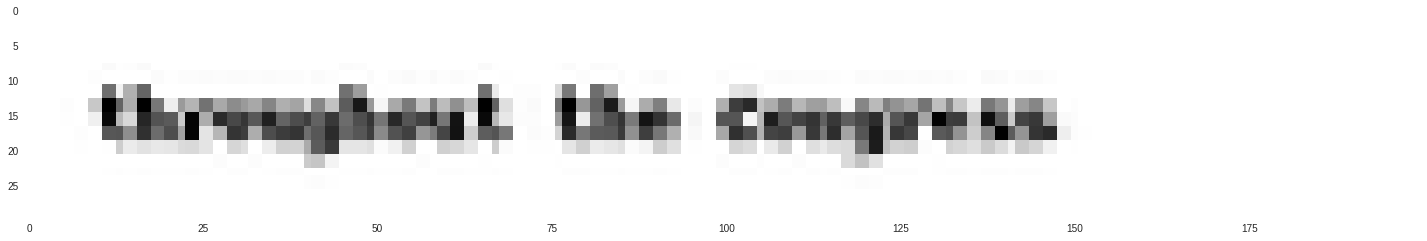

In [0]:
plt.imshow(imread(X_train[0]))

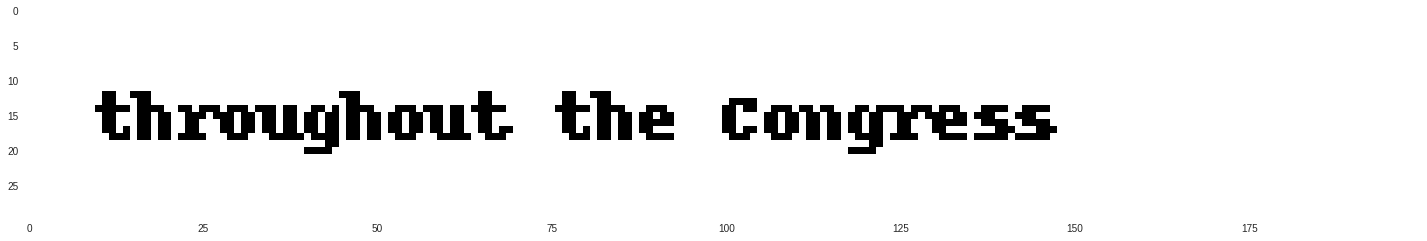

In [0]:
plt.imshow(imread(y_train[0]))

In [0]:
model.evaluate_generator(generator(X_dev,y_dev,batch_size=128))

[0.0011354076199233533, 29.74054641418457, 4.0675824378967285]

In [0]:
test_path = 'drive/My Drive/computer_vision/testing2'
def comparing(model, X, y, batch_size=10):
  
  for b, (source, target) in enumerate(generator(X, y, batch_size=batch_size)):
    
    results = model.predict(source)
    
    fig, axes = plt.subplots(len(results), 3,  figsize=(25,5*len(results)))
    
    for i, result in enumerate(results):                
#       mae = np.mean(np.abs(result - target[i]))*255
#       mse = np.mean((result - target[i])**2)*255                      
#       plt.suptitle("mea {} mse {}".format(mae,mse)) 

      axes[i,0].imshow(source[i].reshape(30,200), cmap='gray')
      axes[i,1].imshow(result.reshape(30,200), cmap='gray')    
      axes[i,2].imshow(target[i].reshape(30,200), cmap='gray')
#     print(i, len(results))
    fig.savefig(os.path.join(test_path,'test_{}-{}.png'.format(b*batch_size, b*batch_size+len(results))))
#   fig.show()

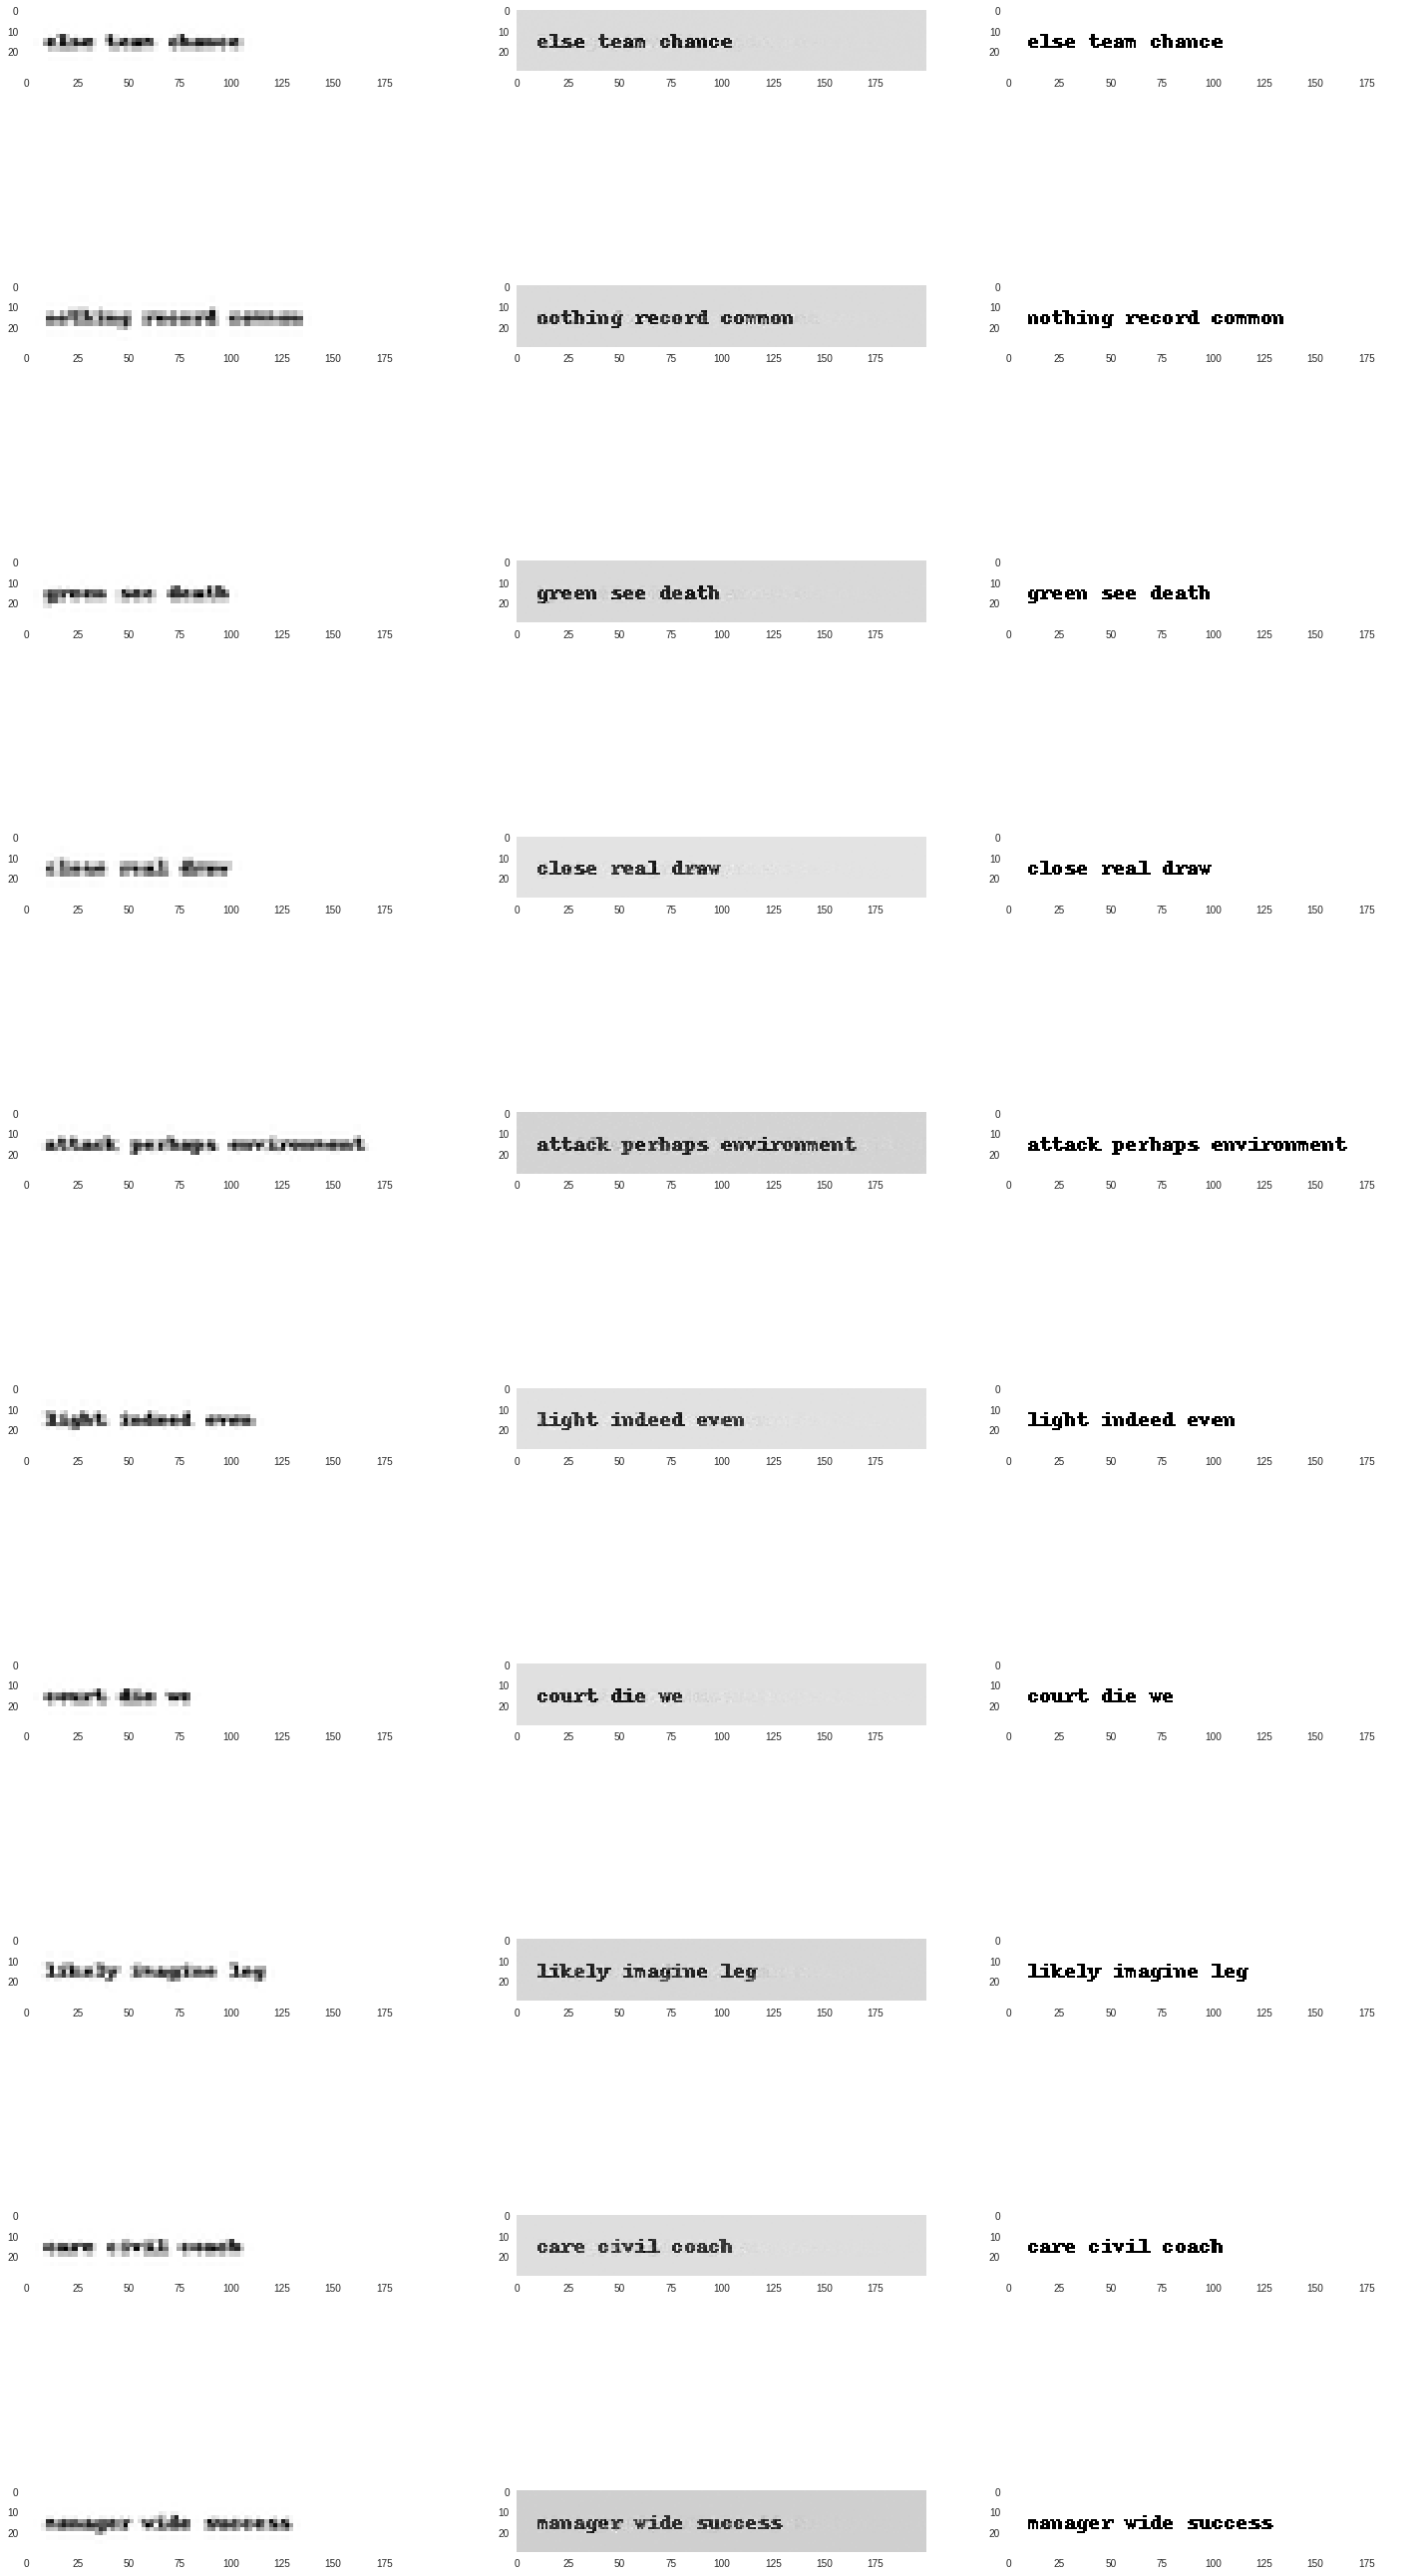

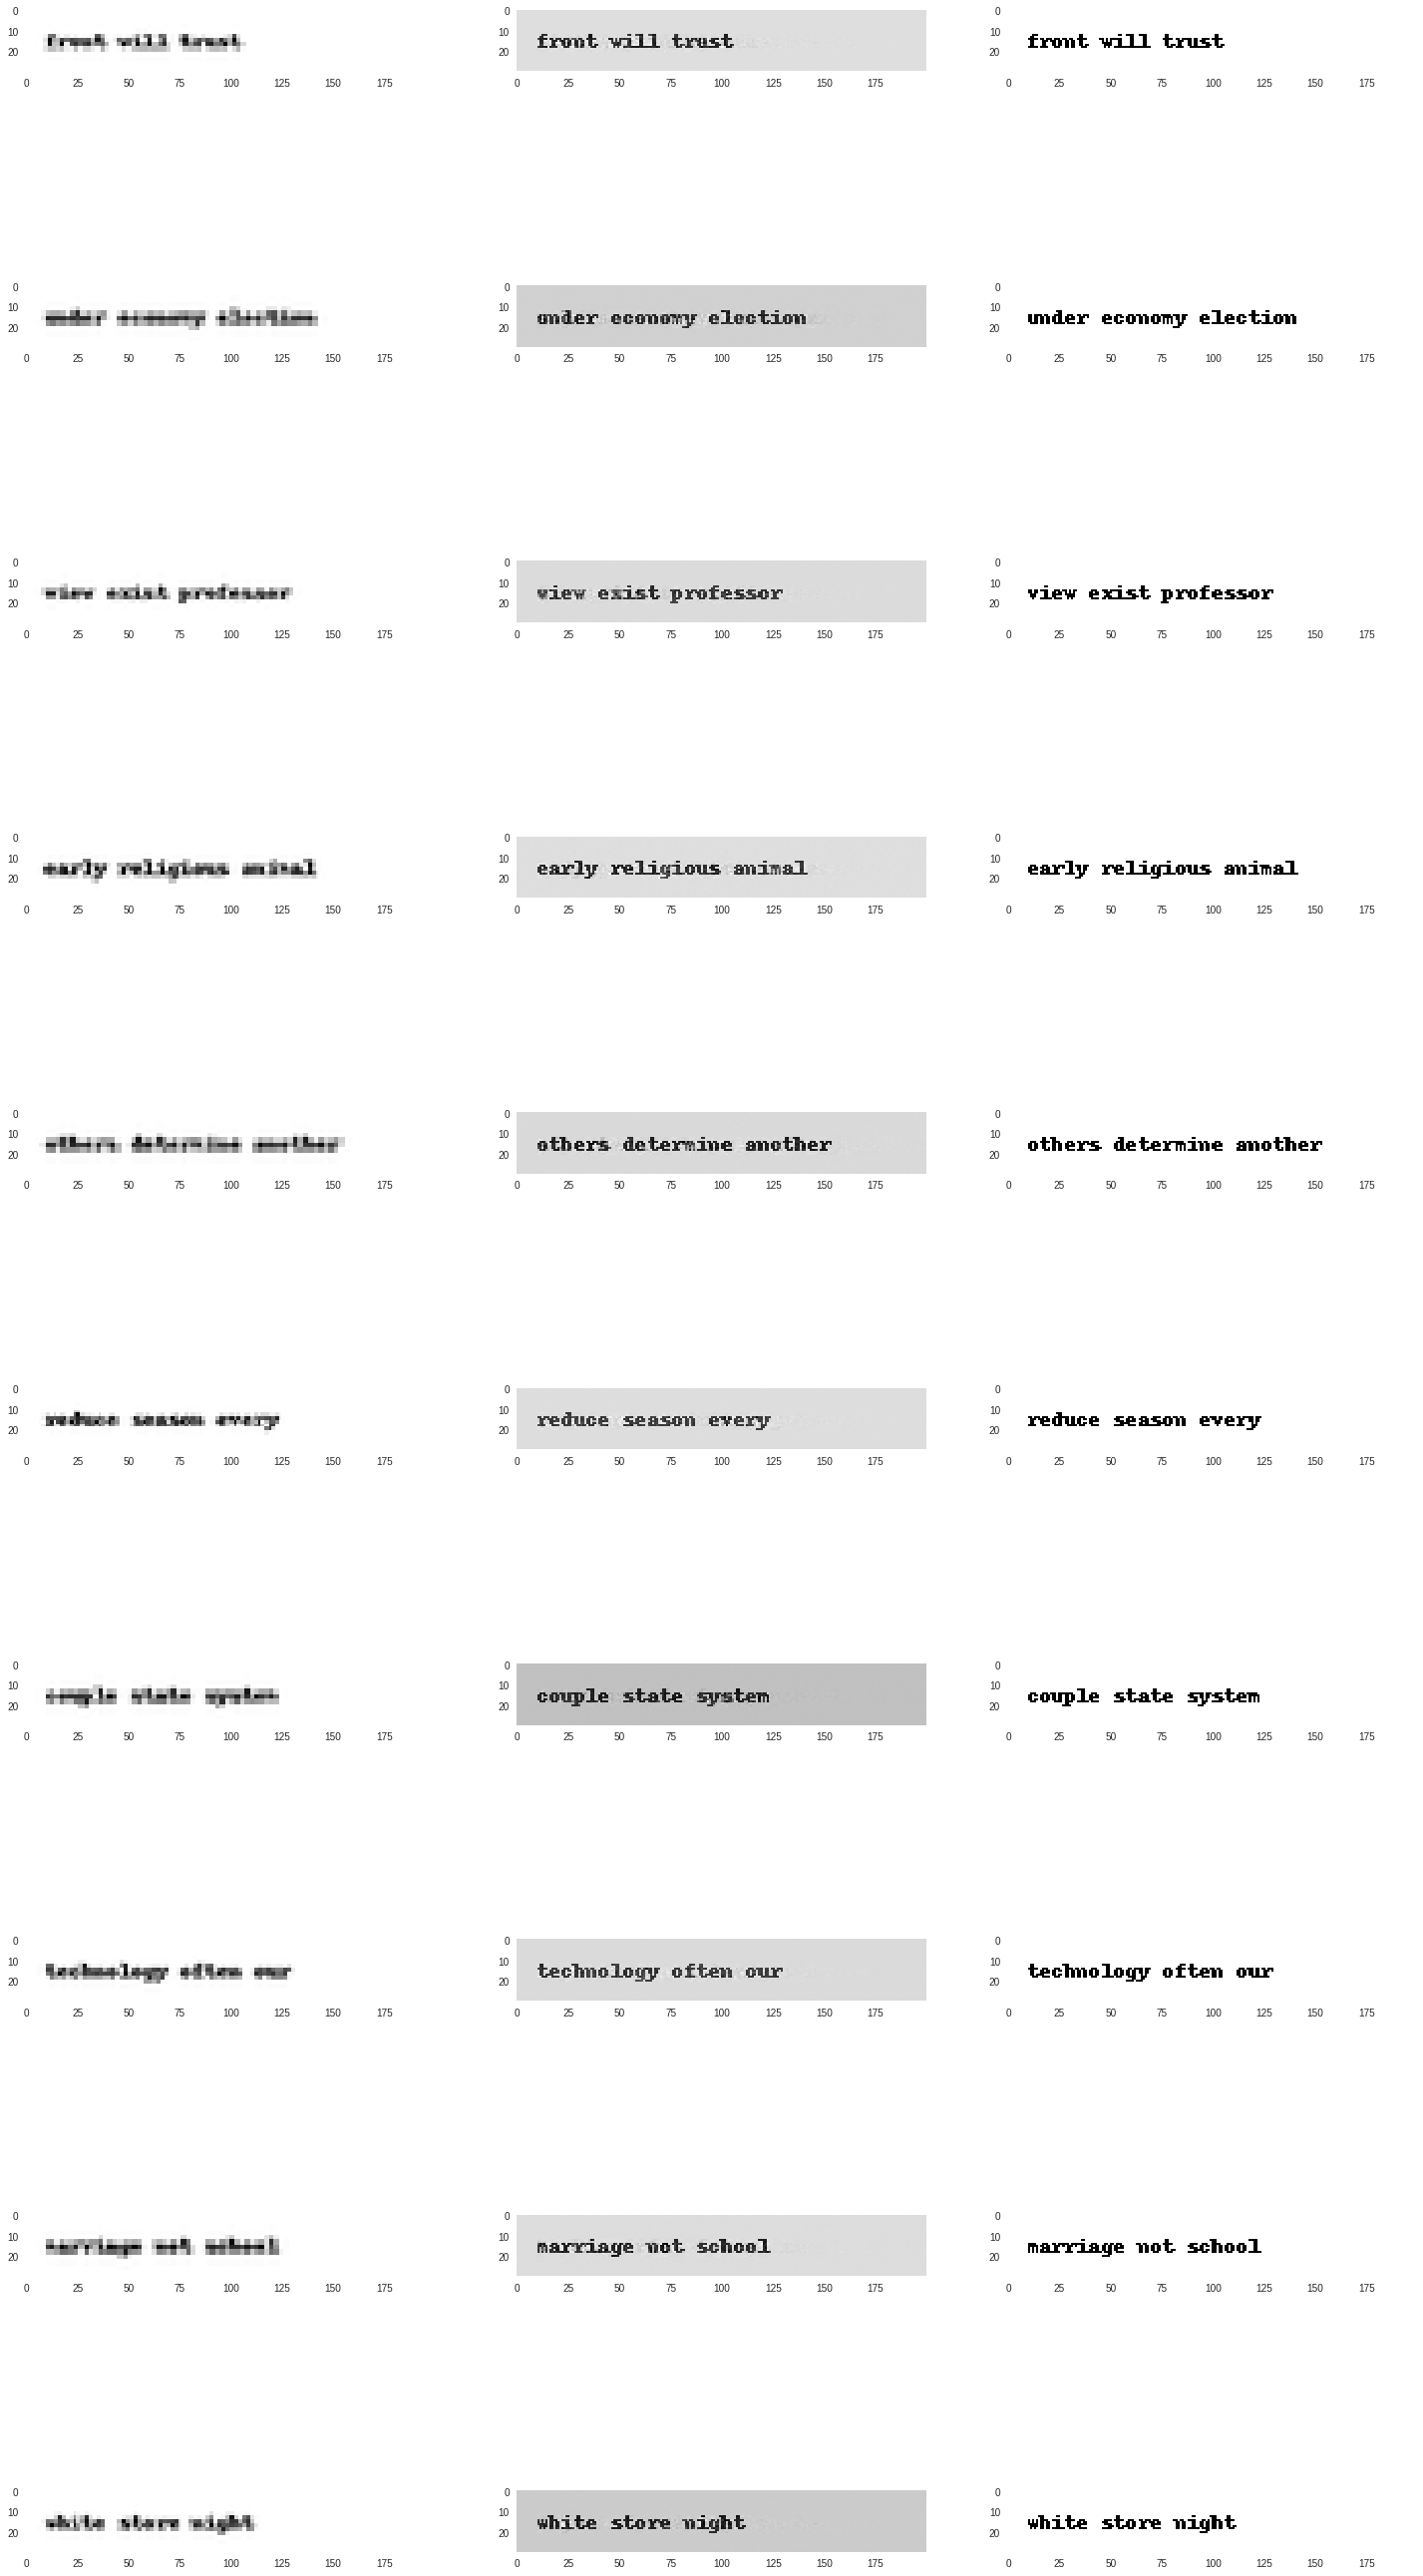

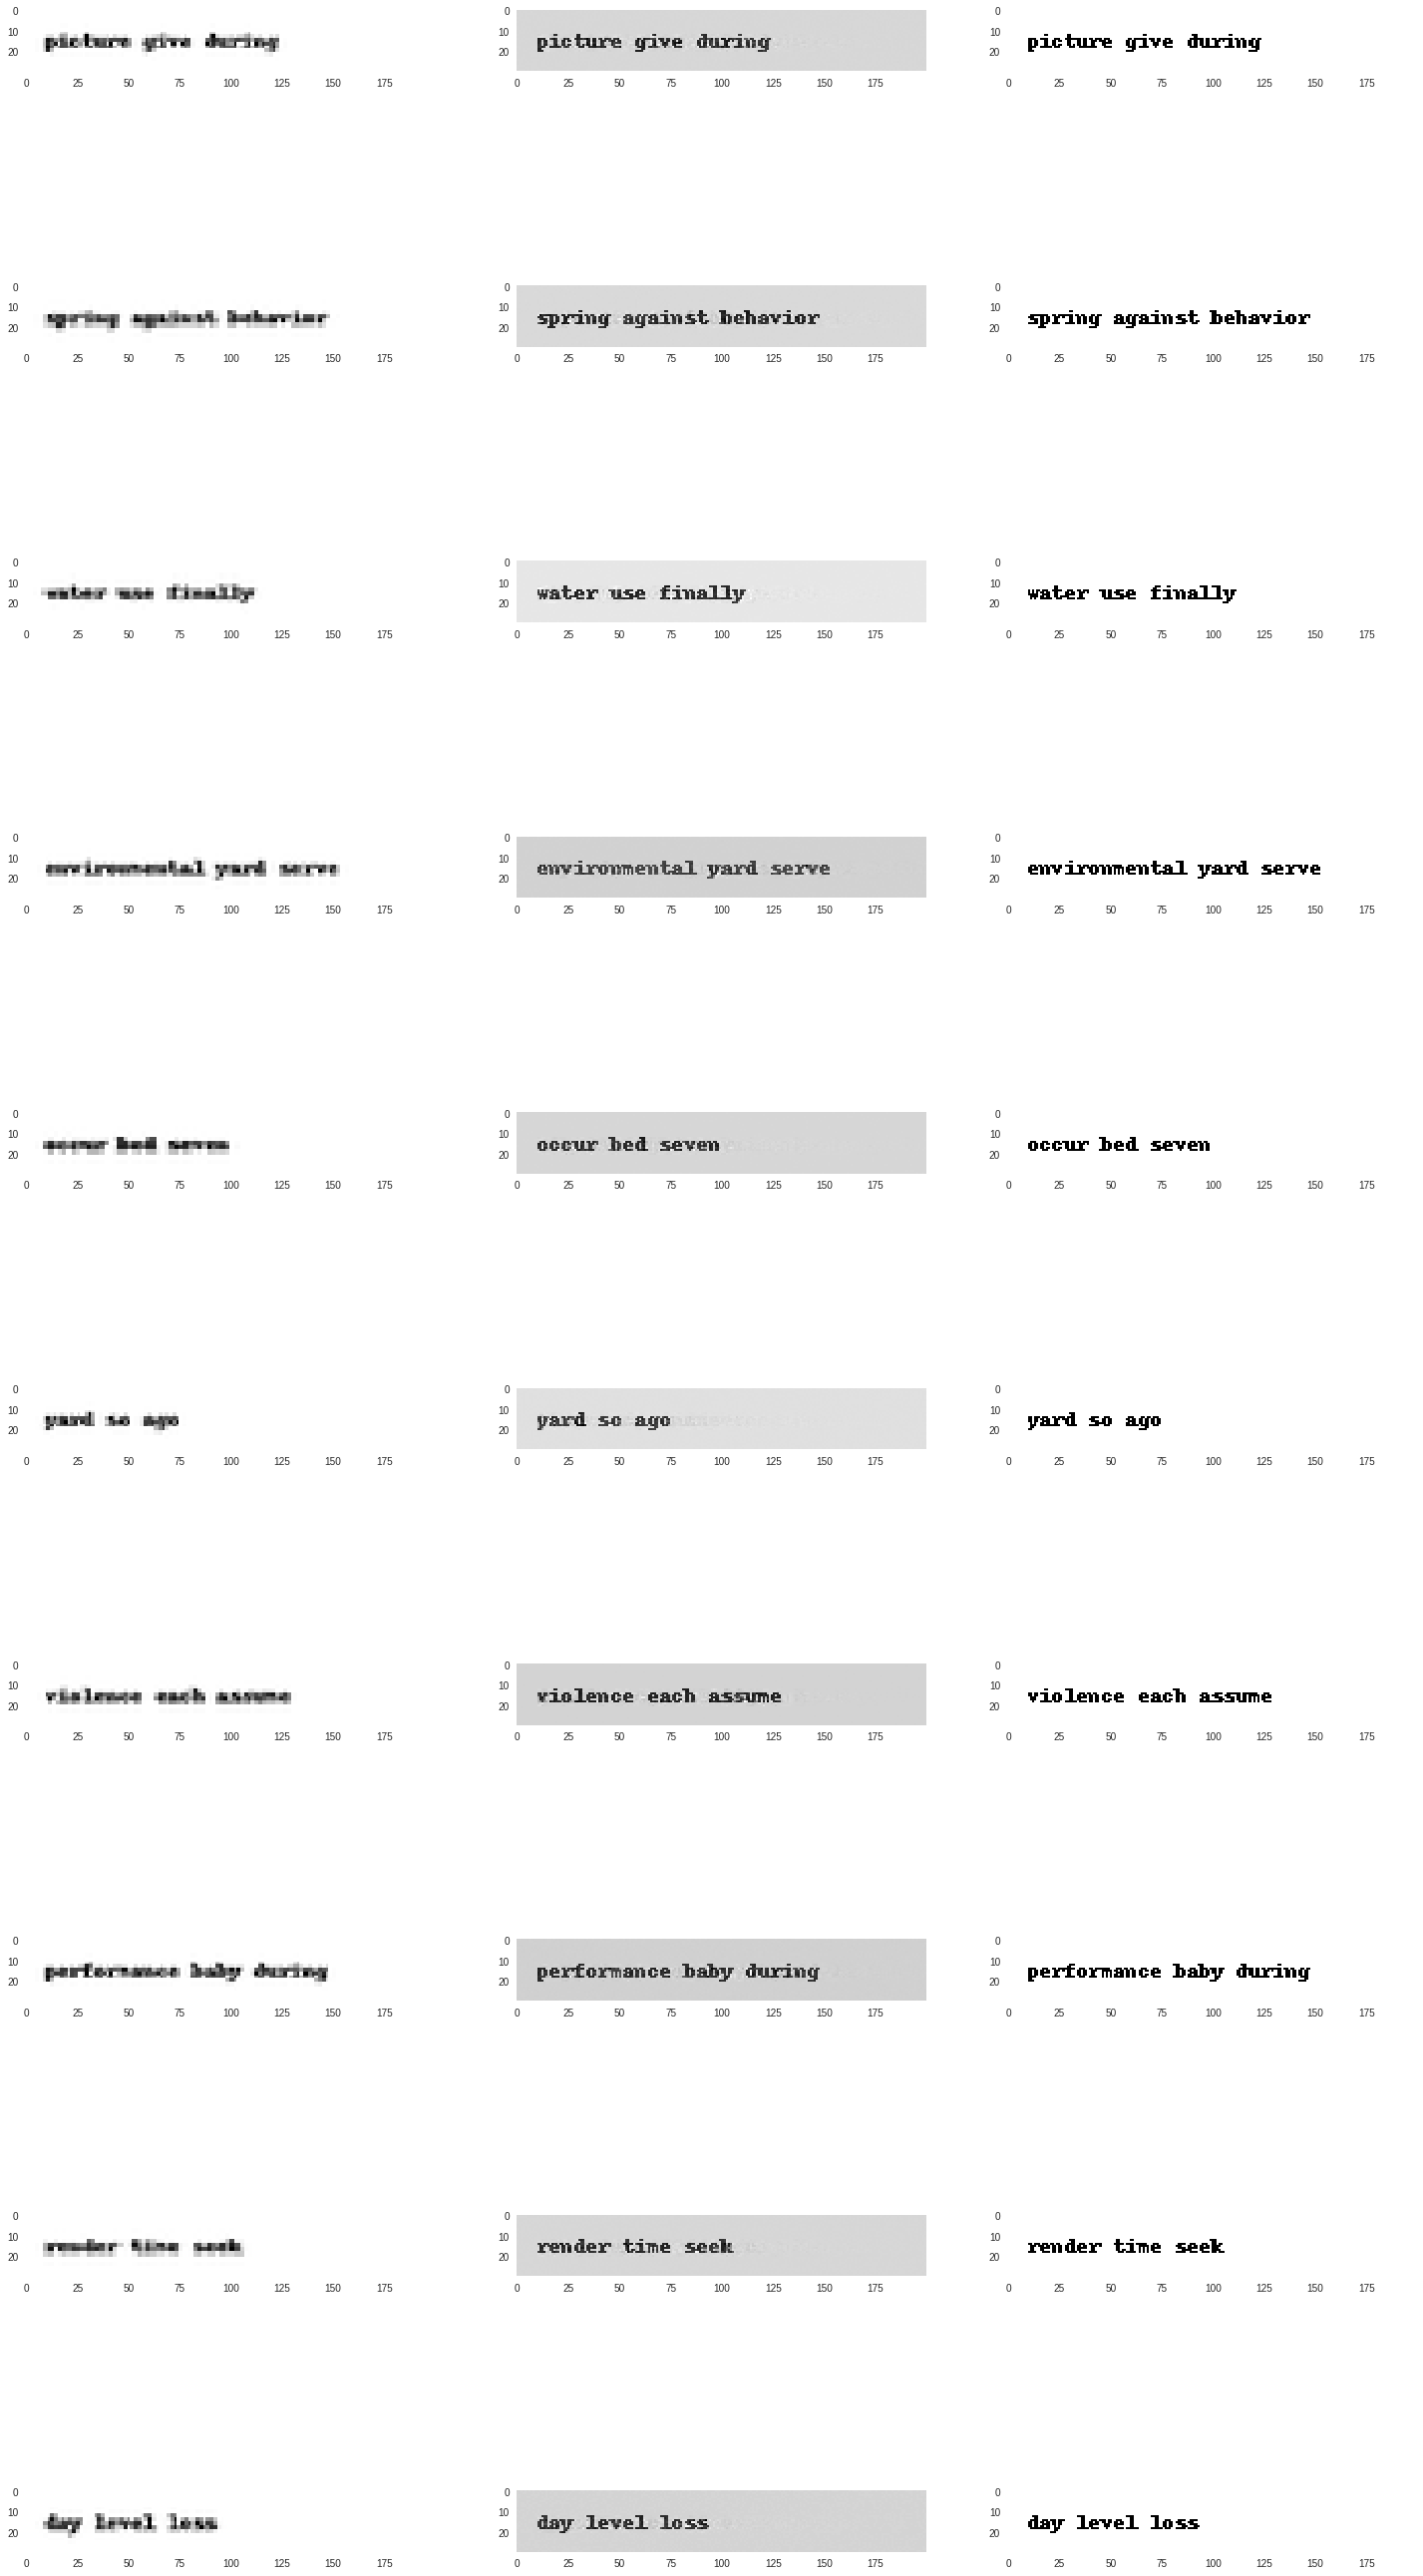

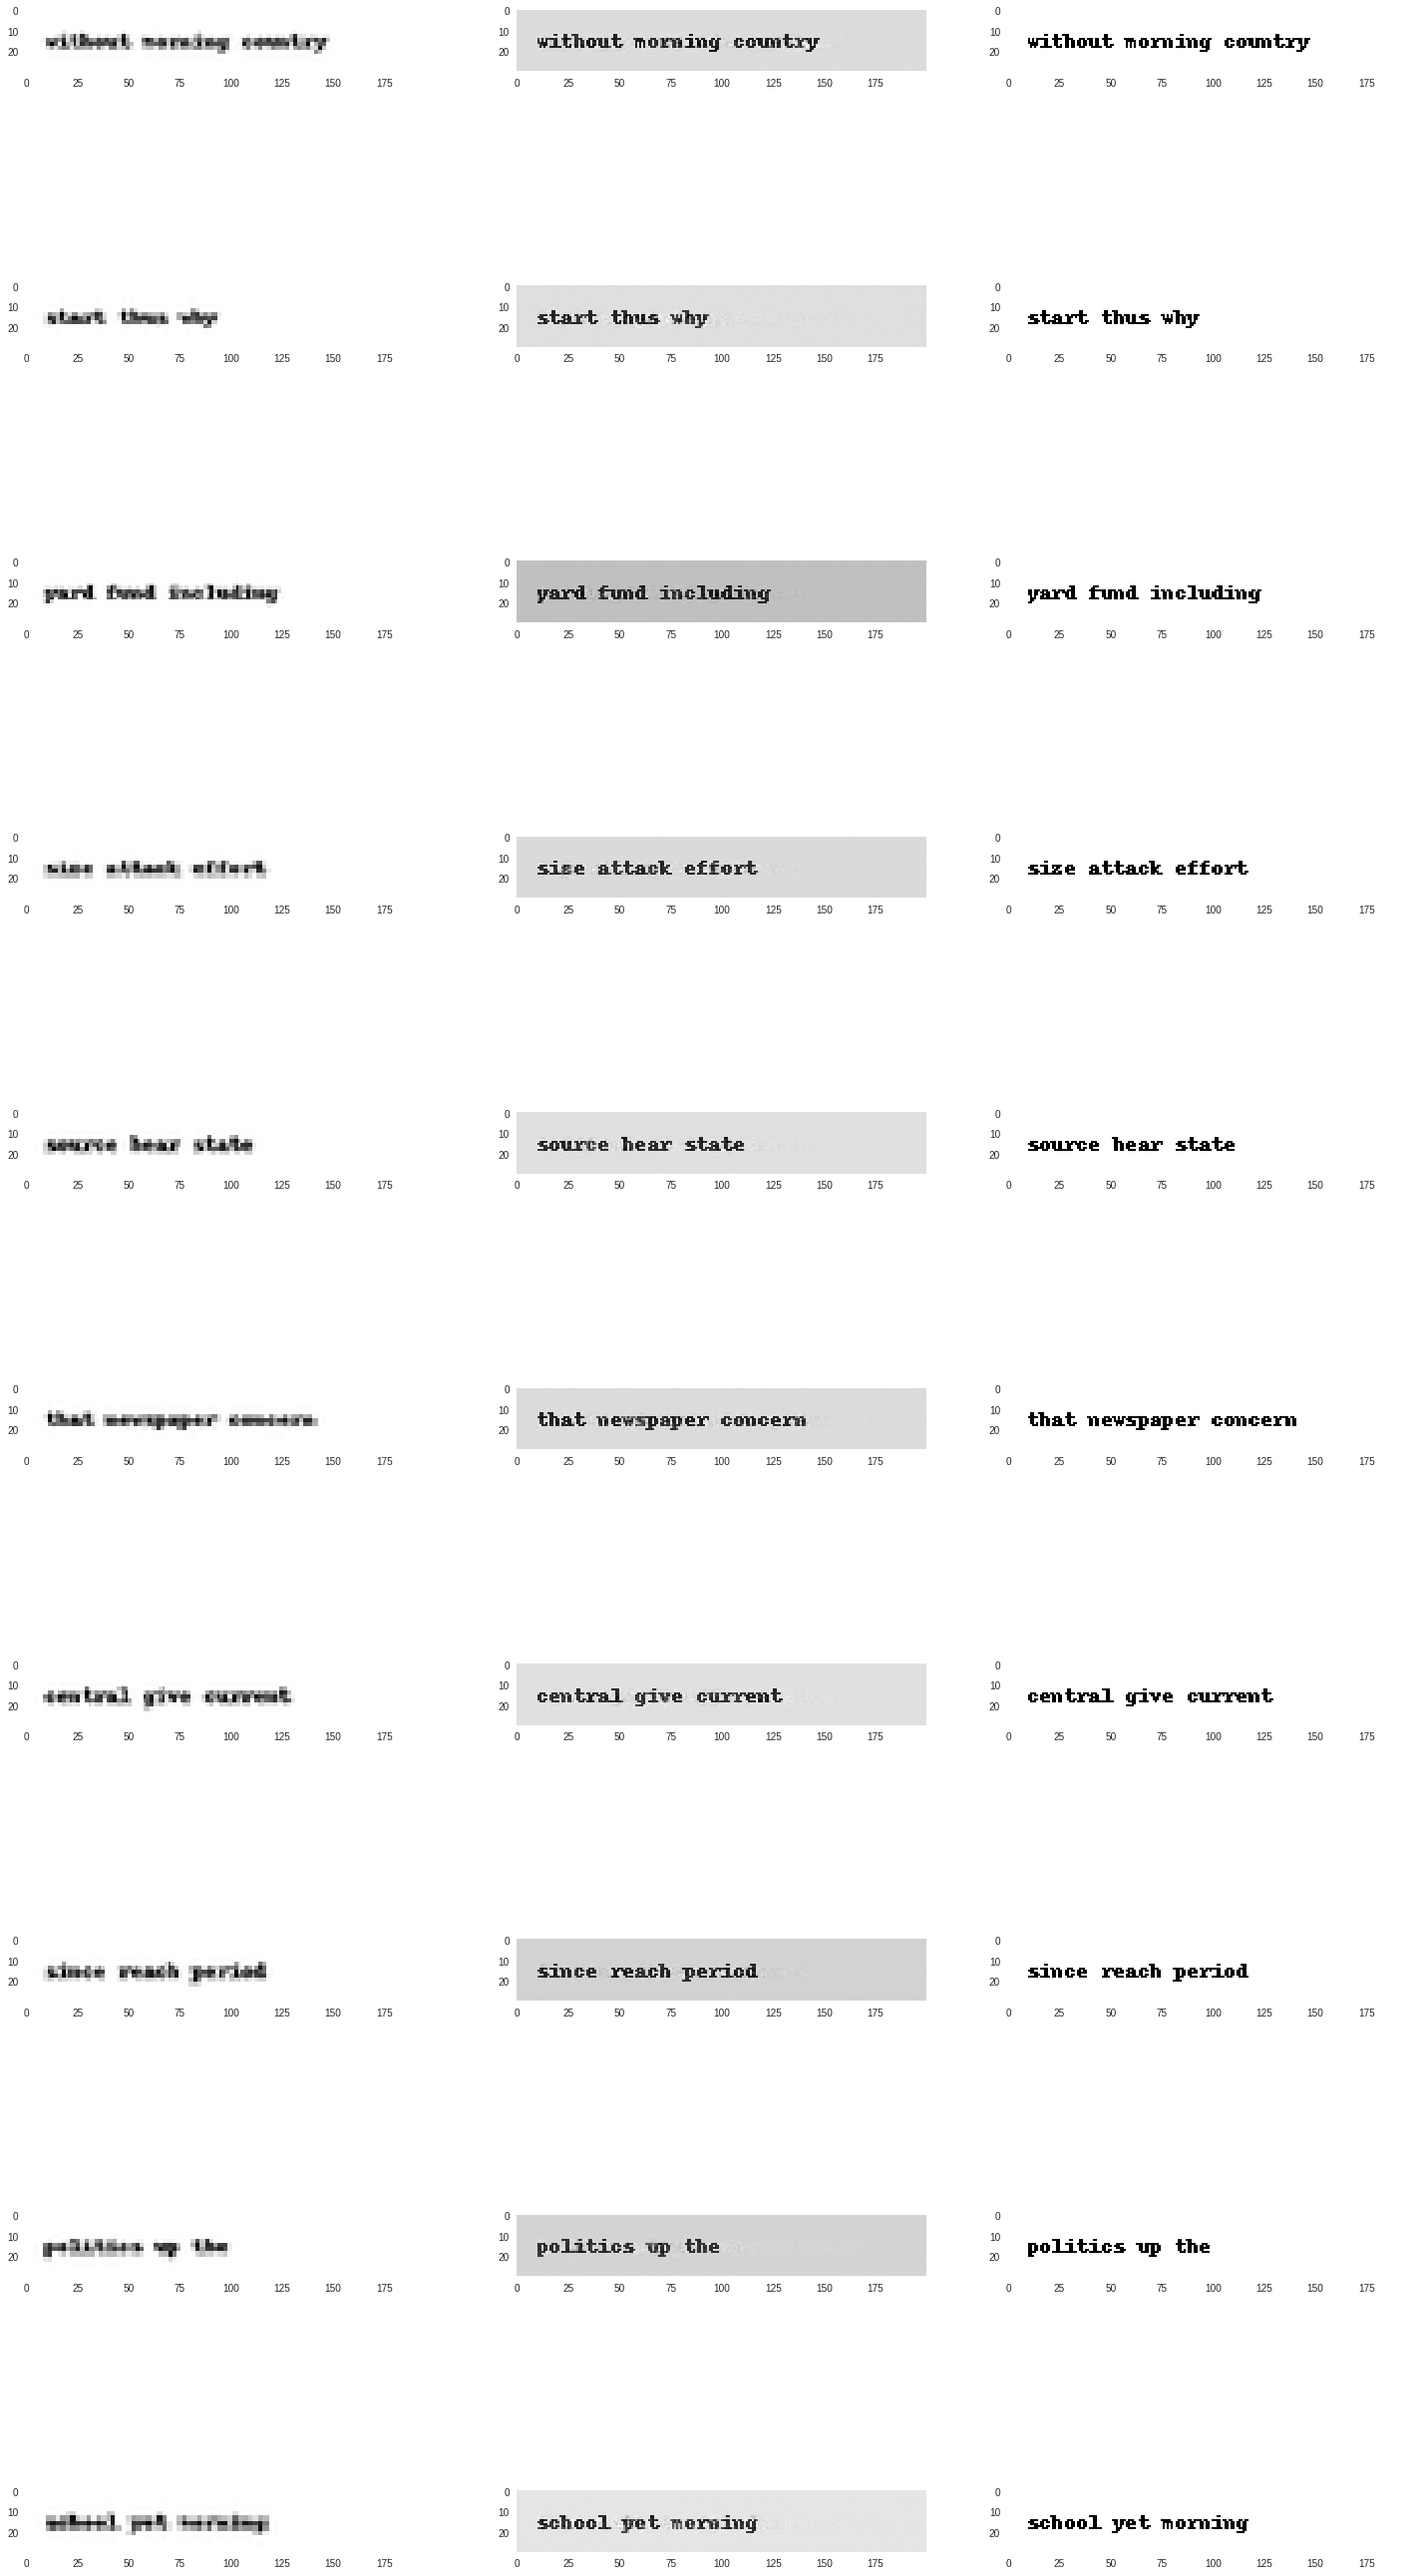

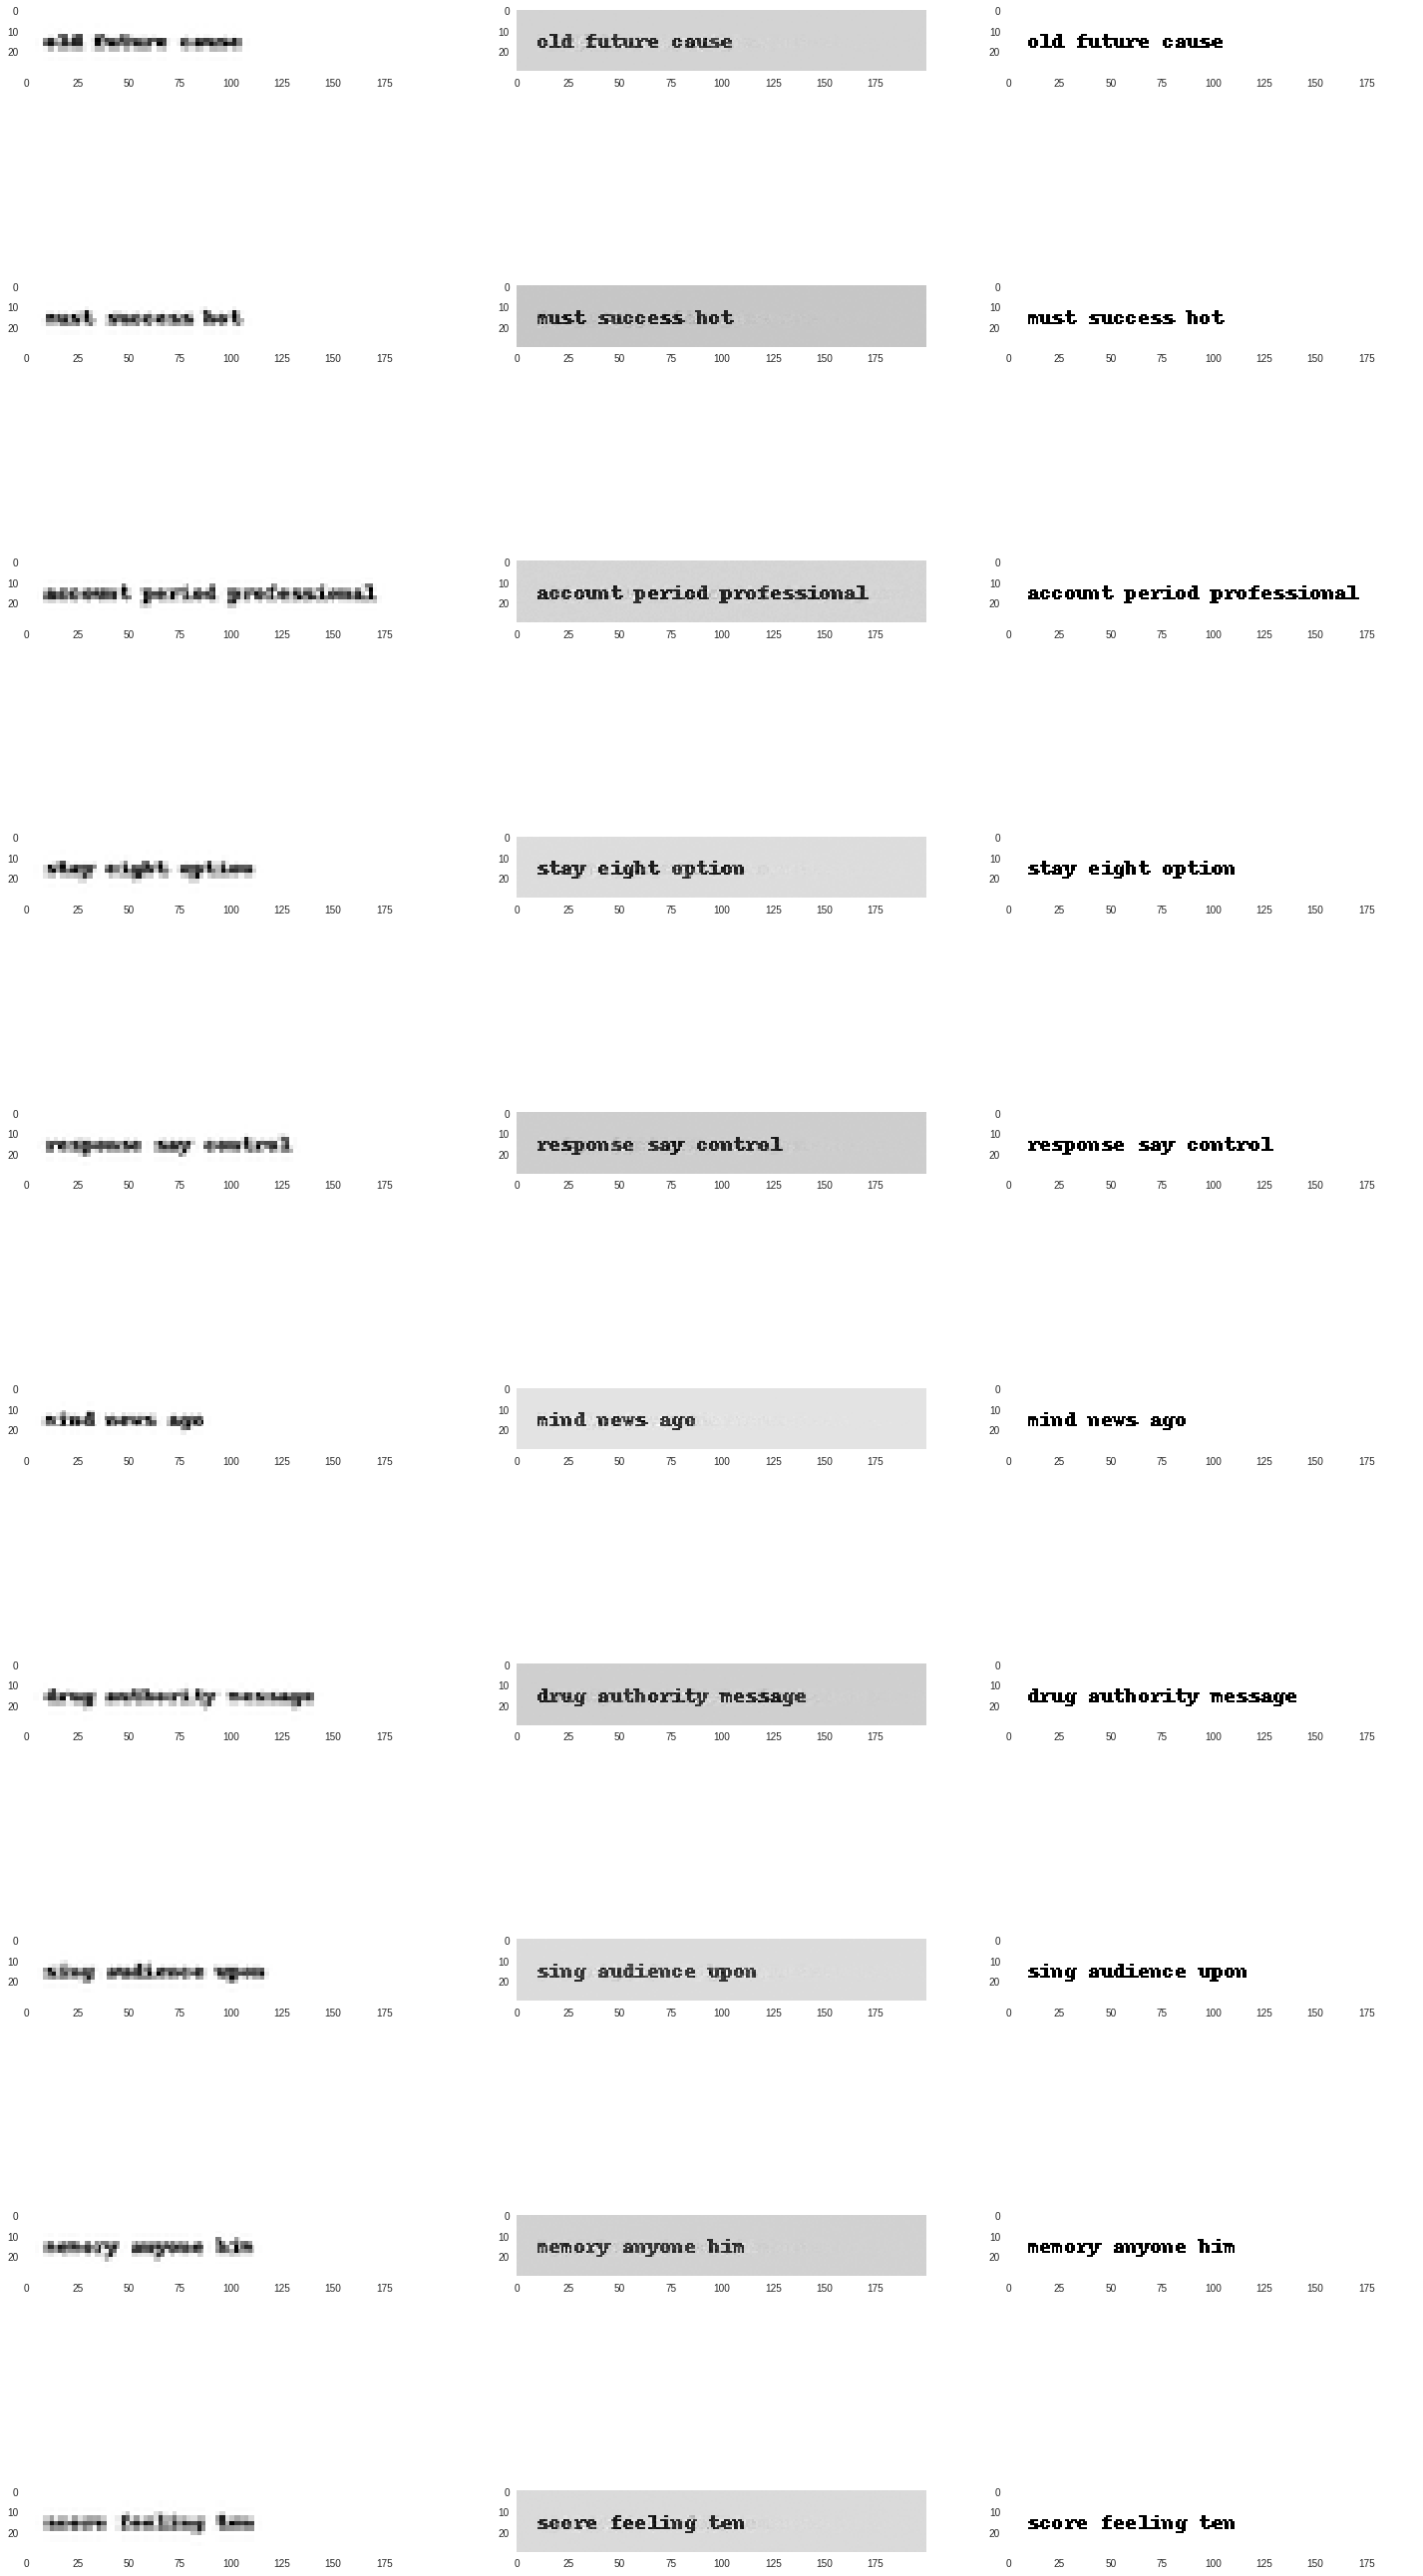

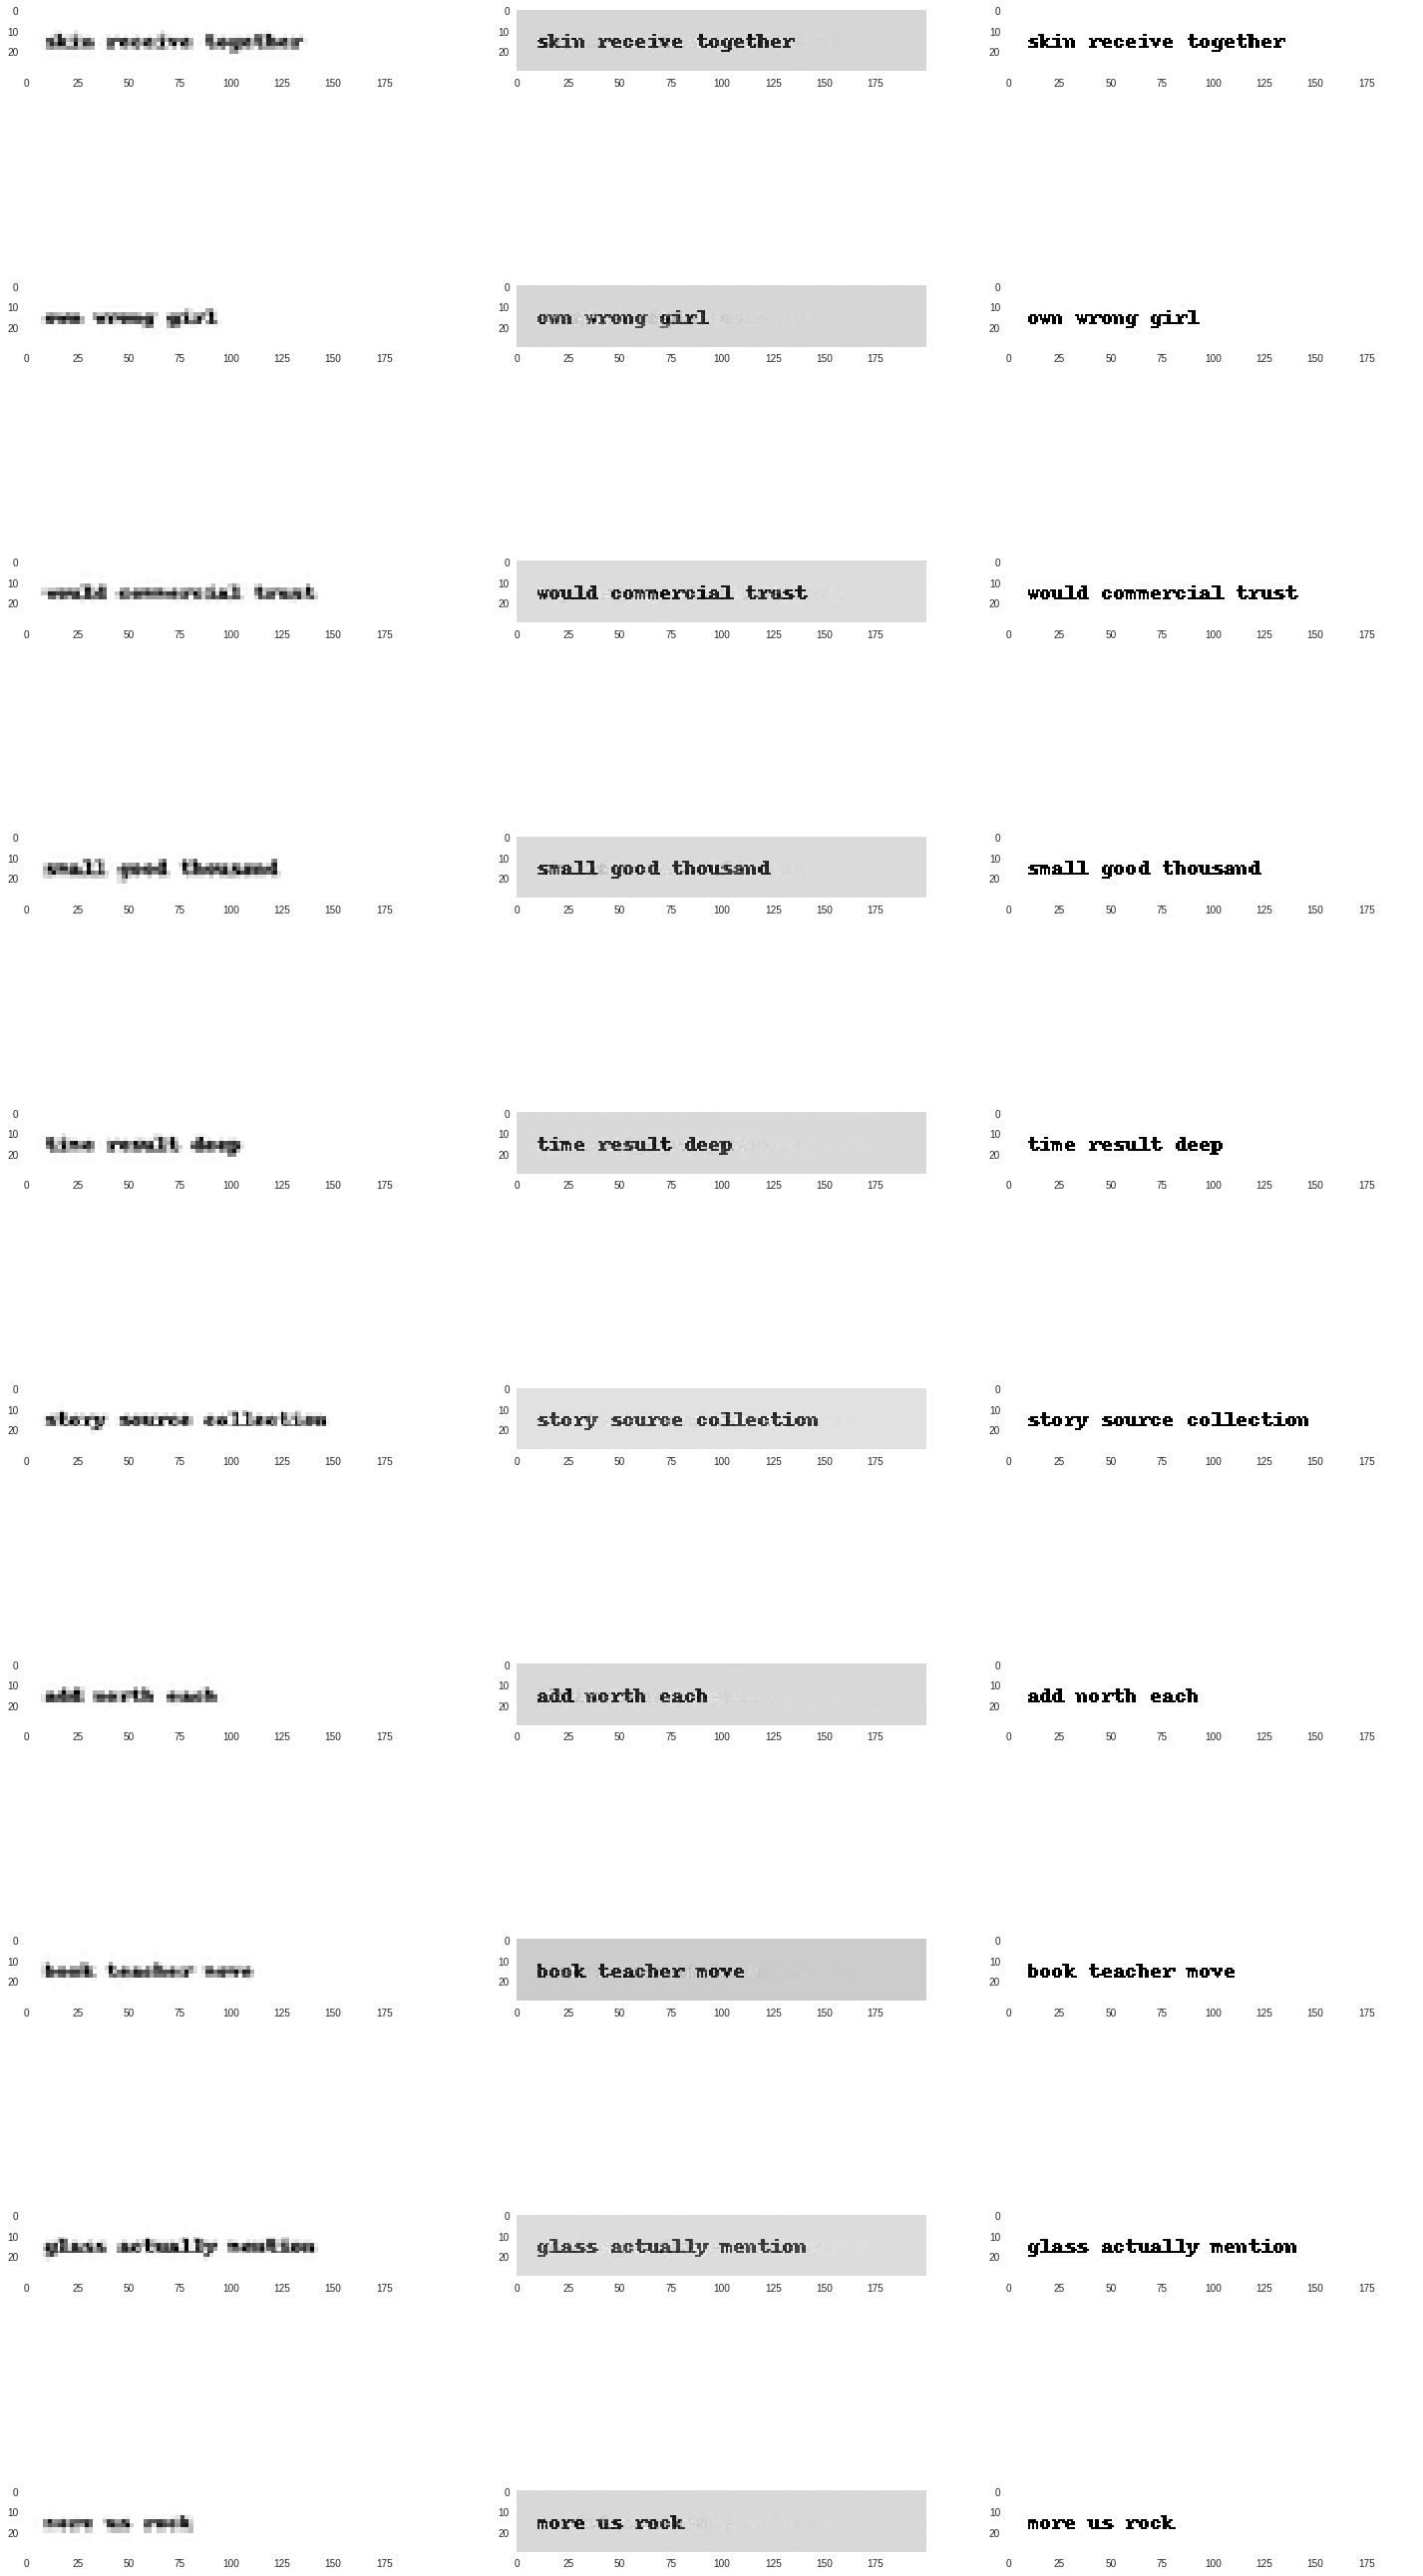

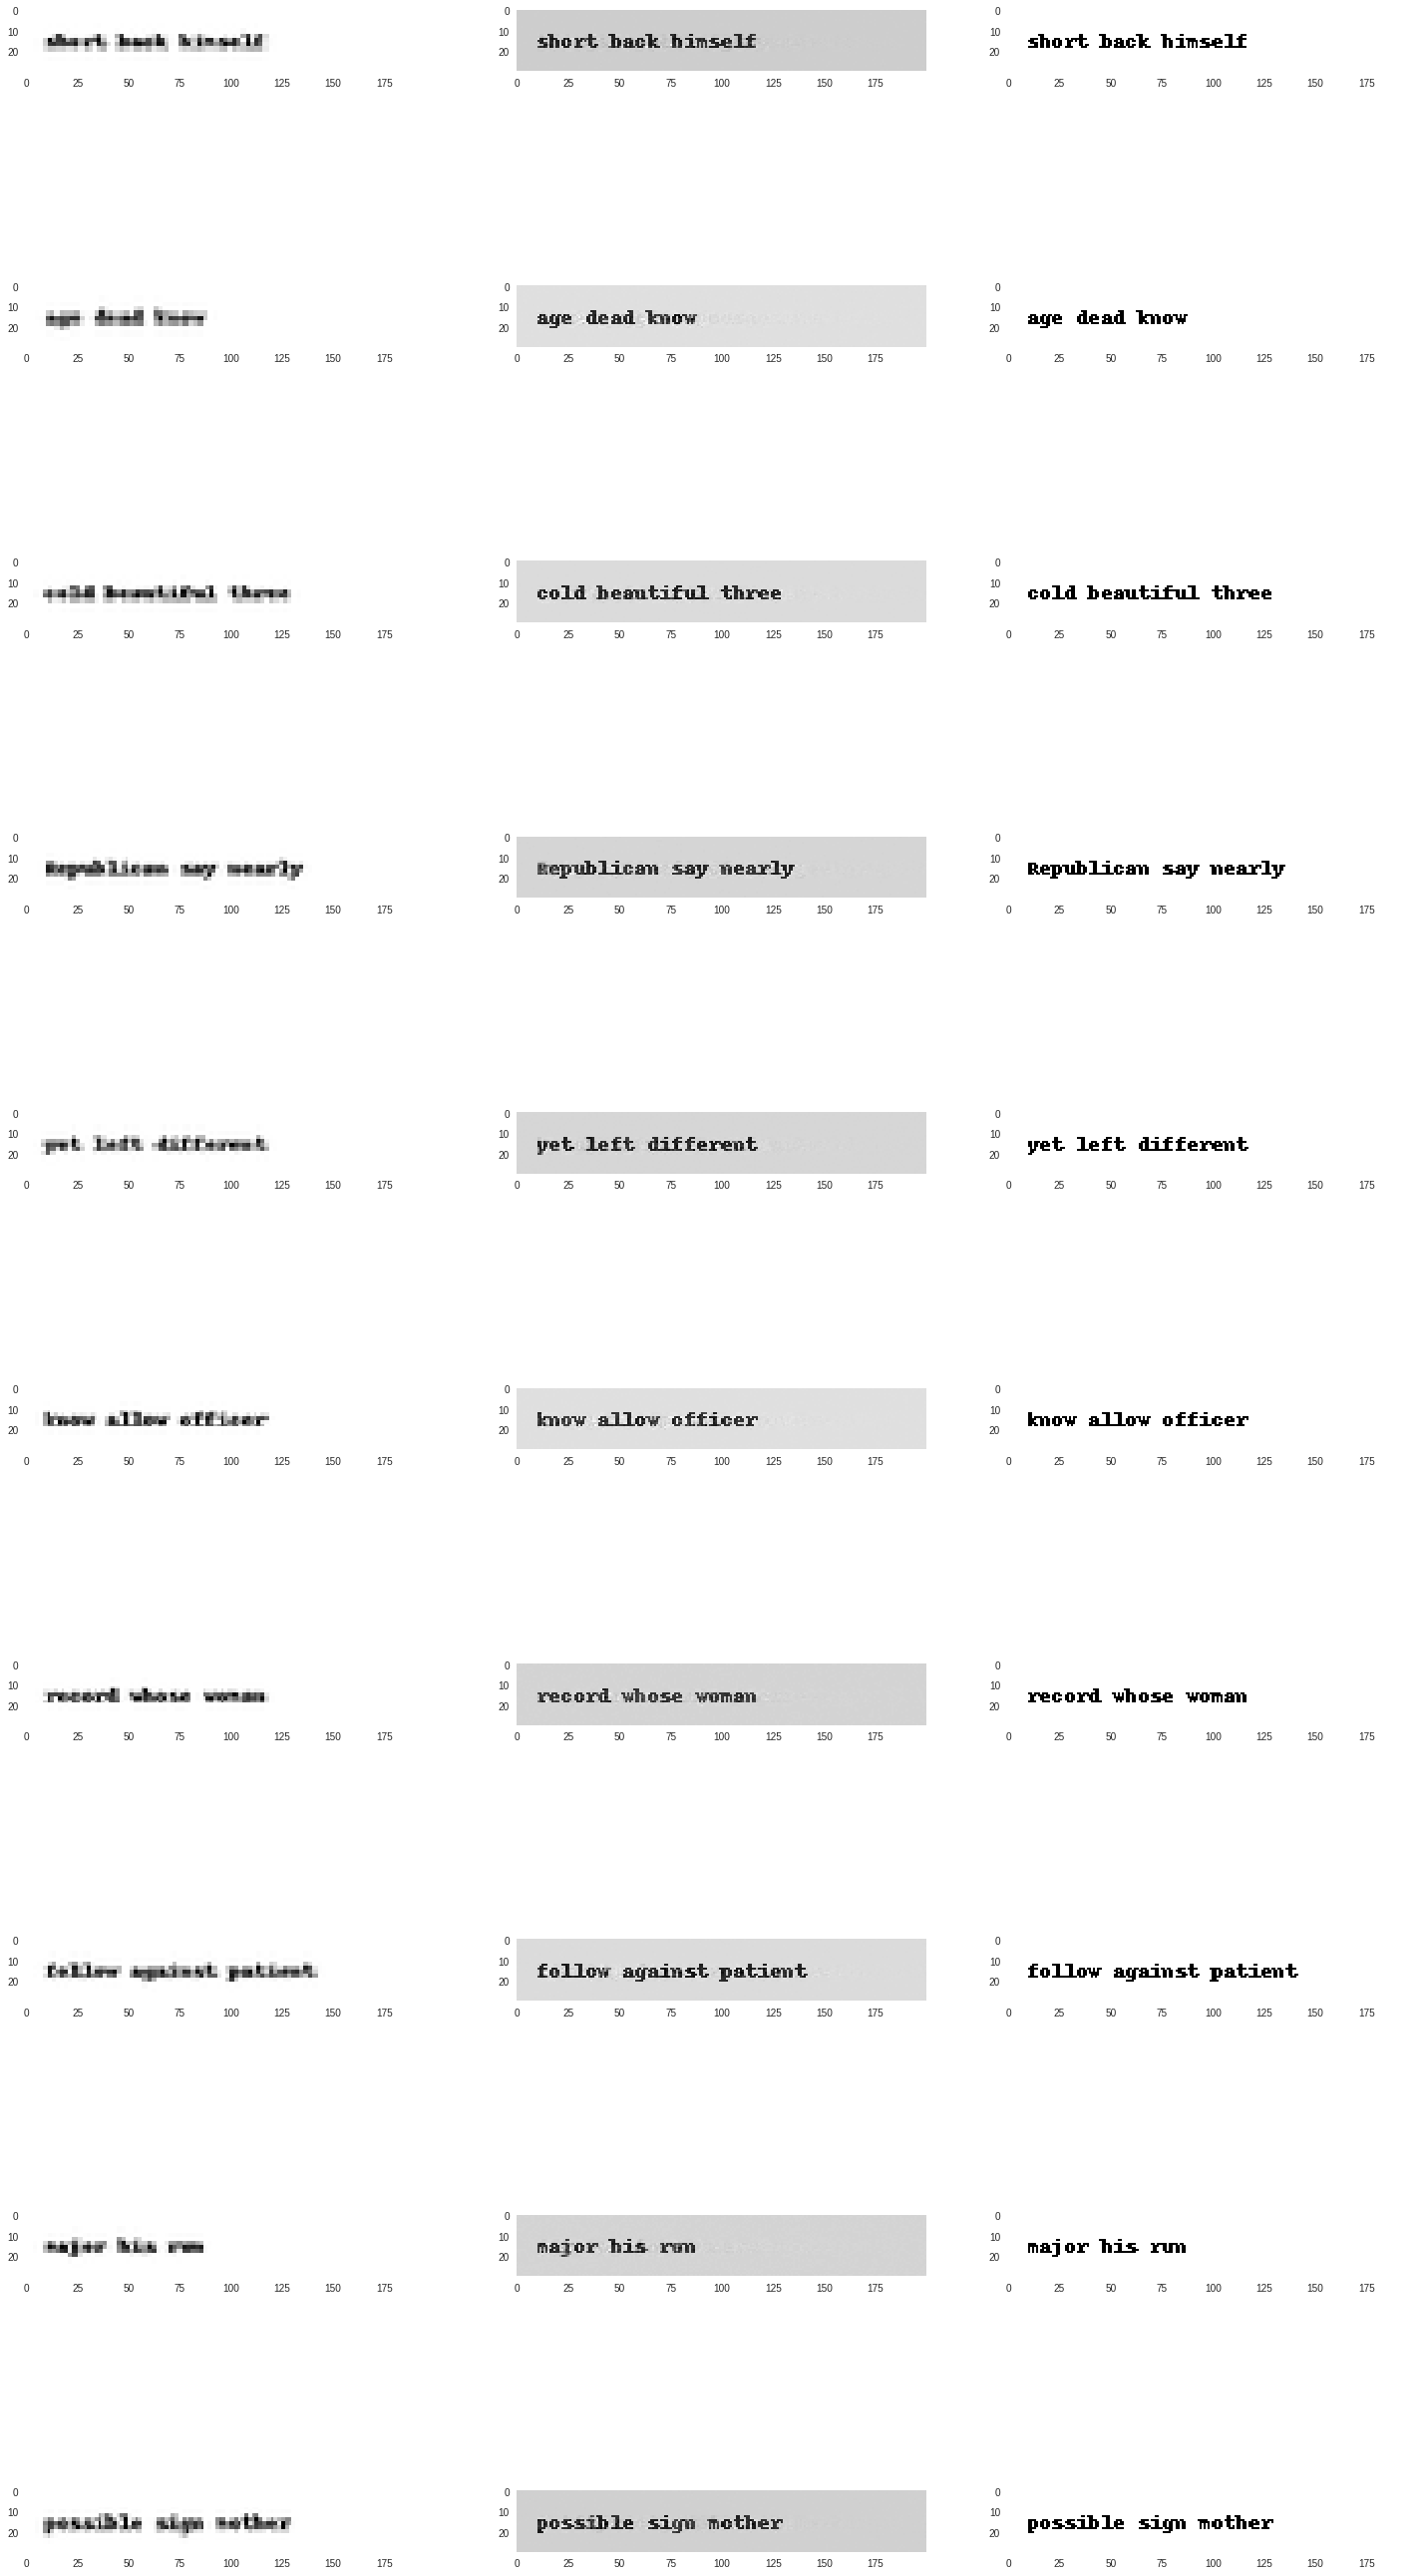

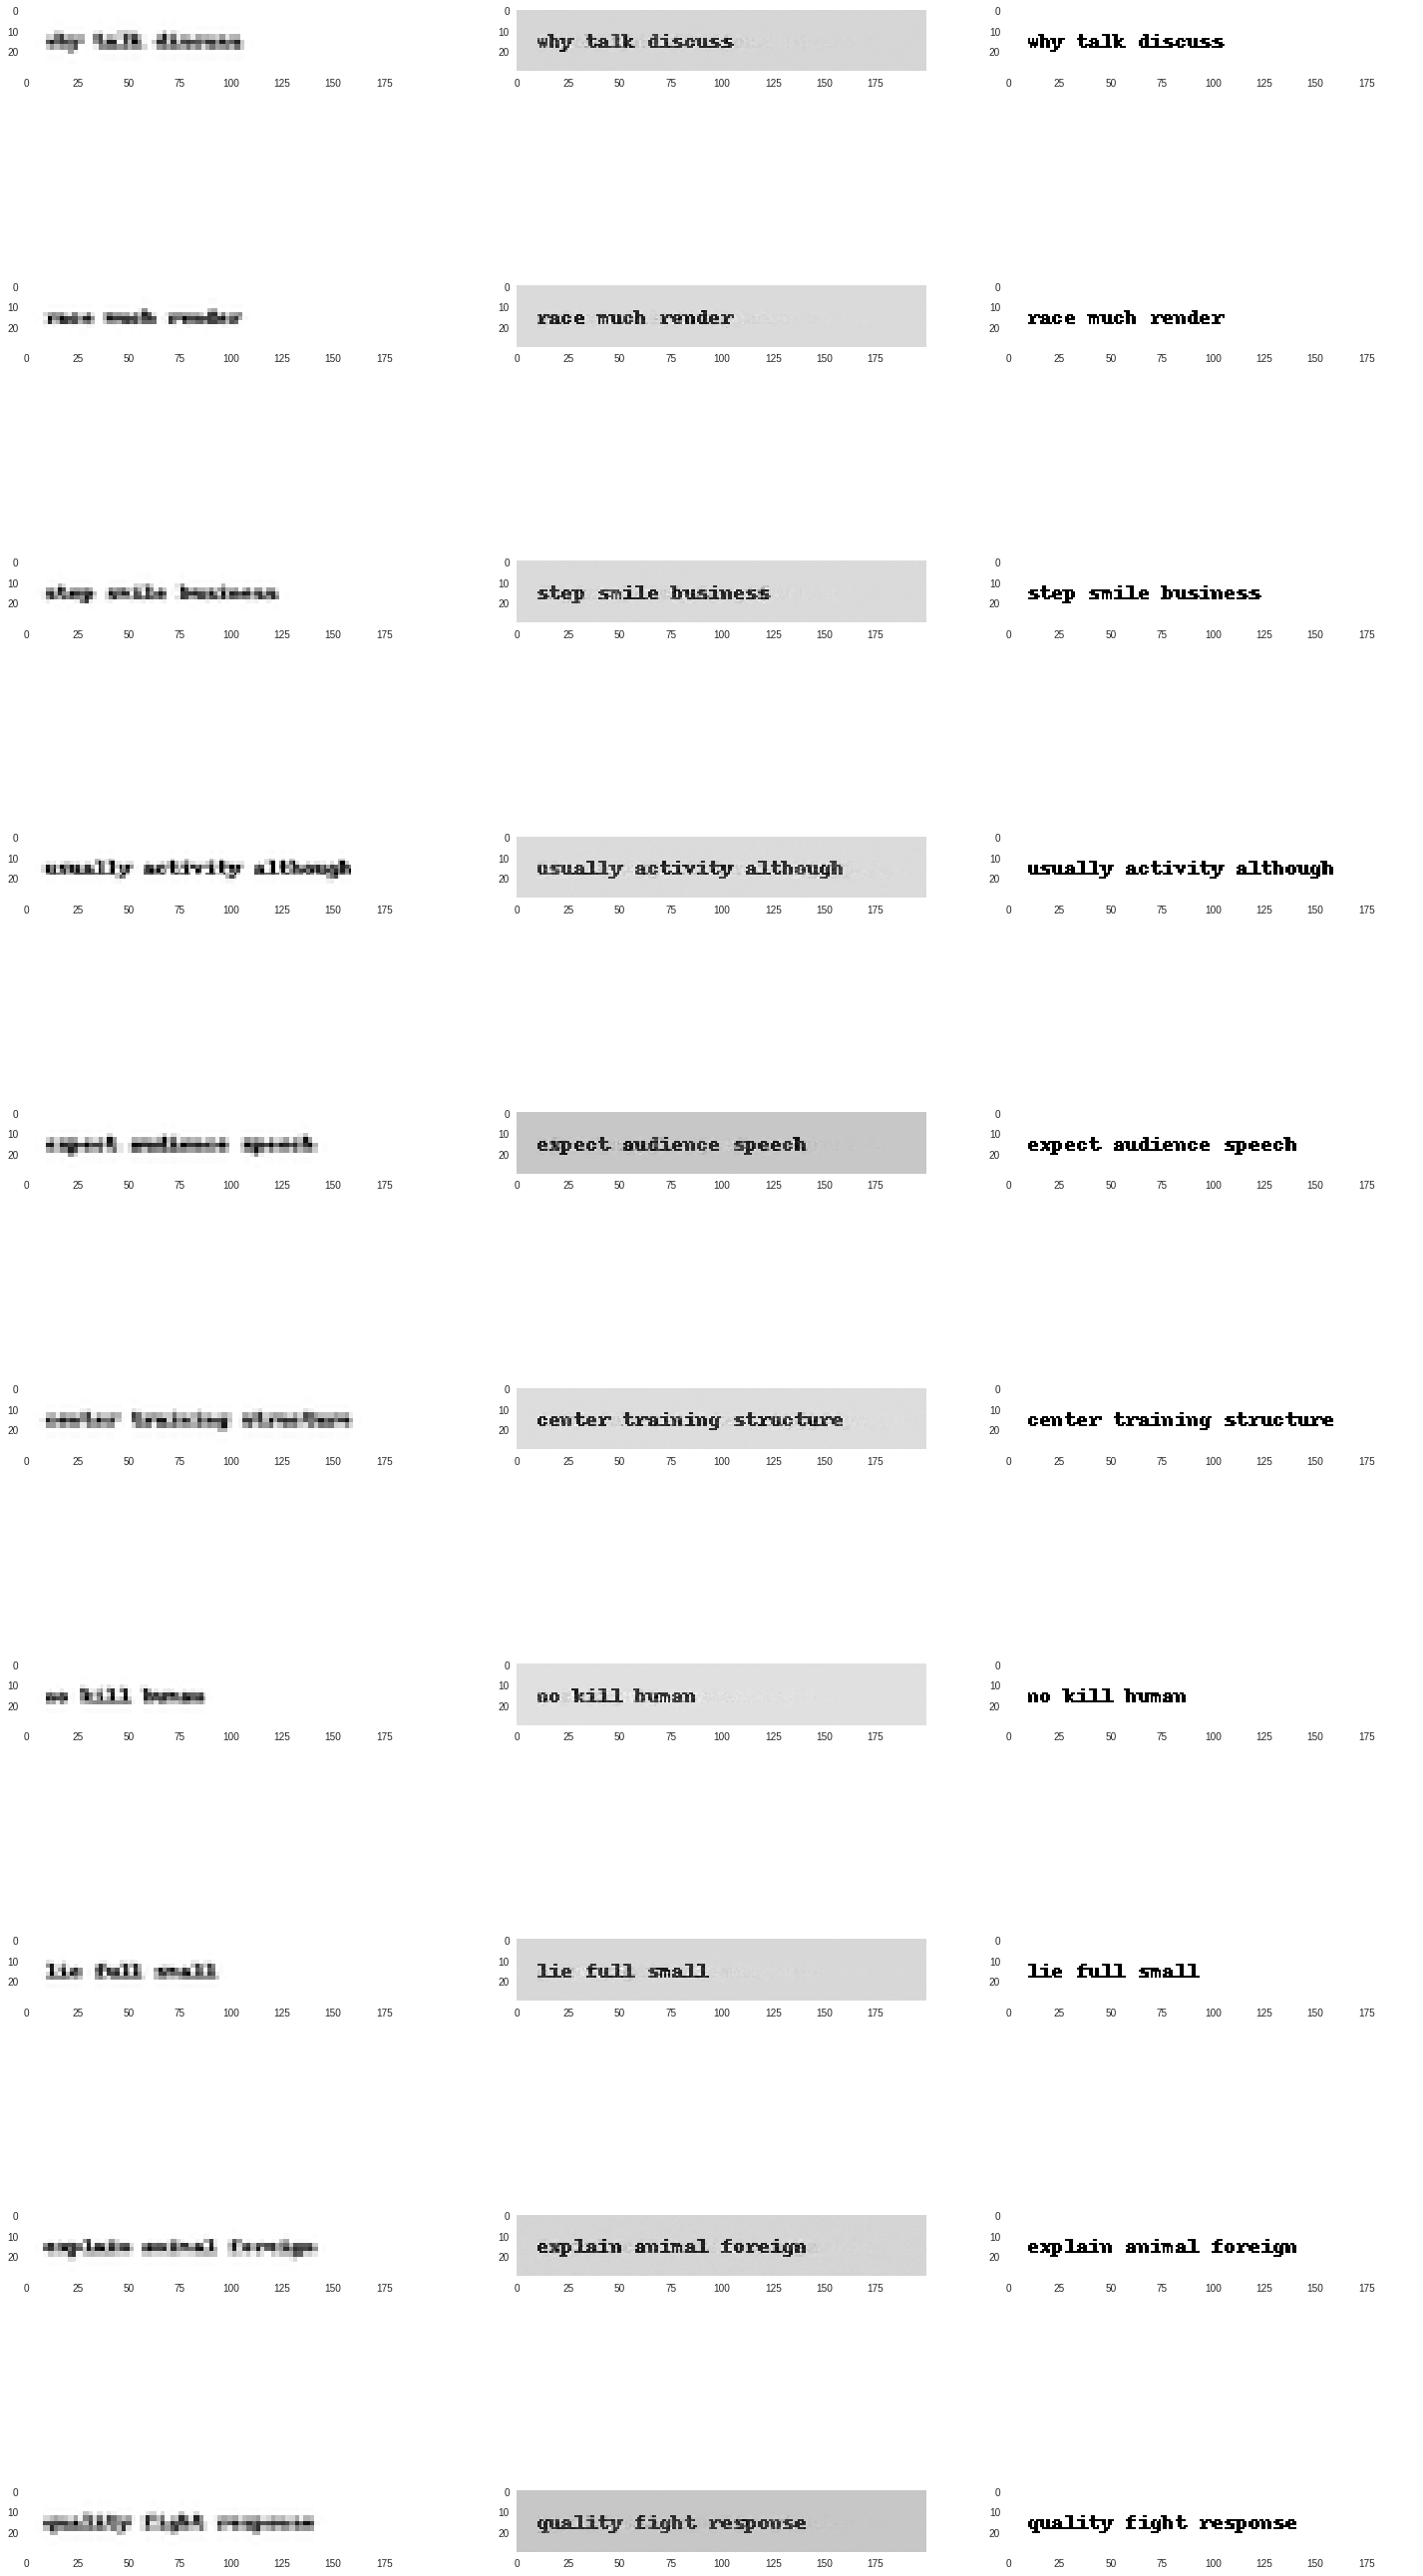

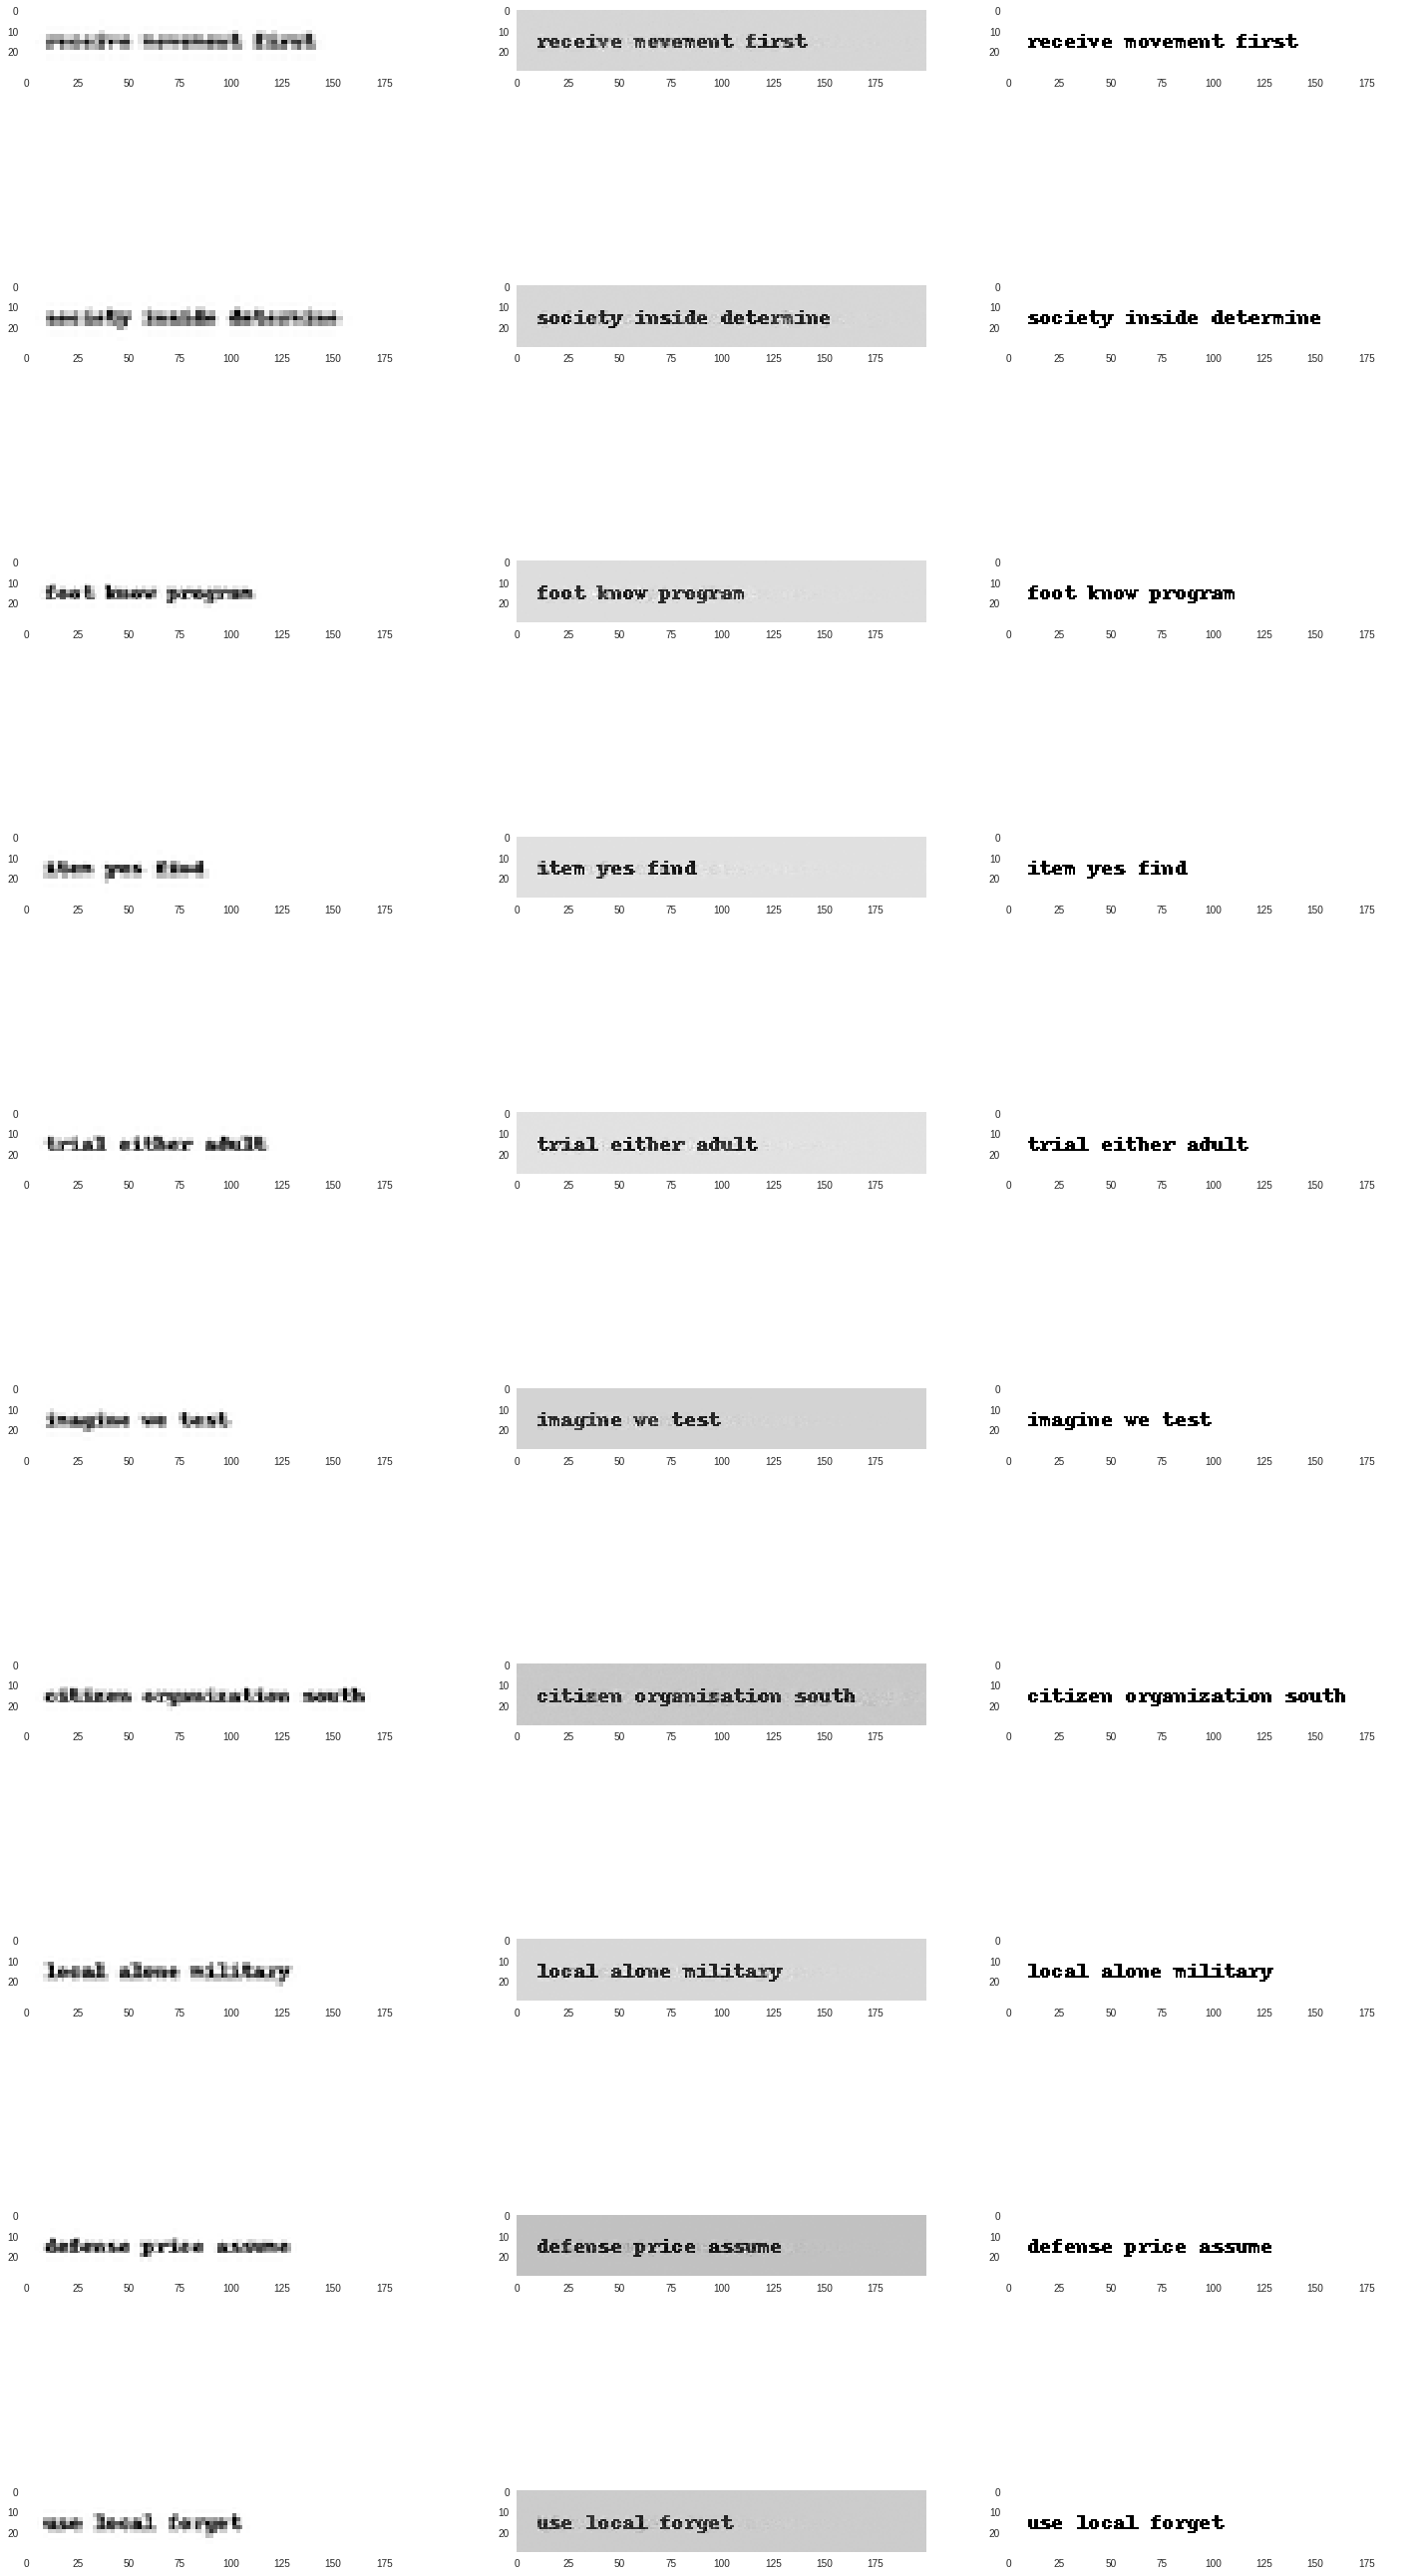

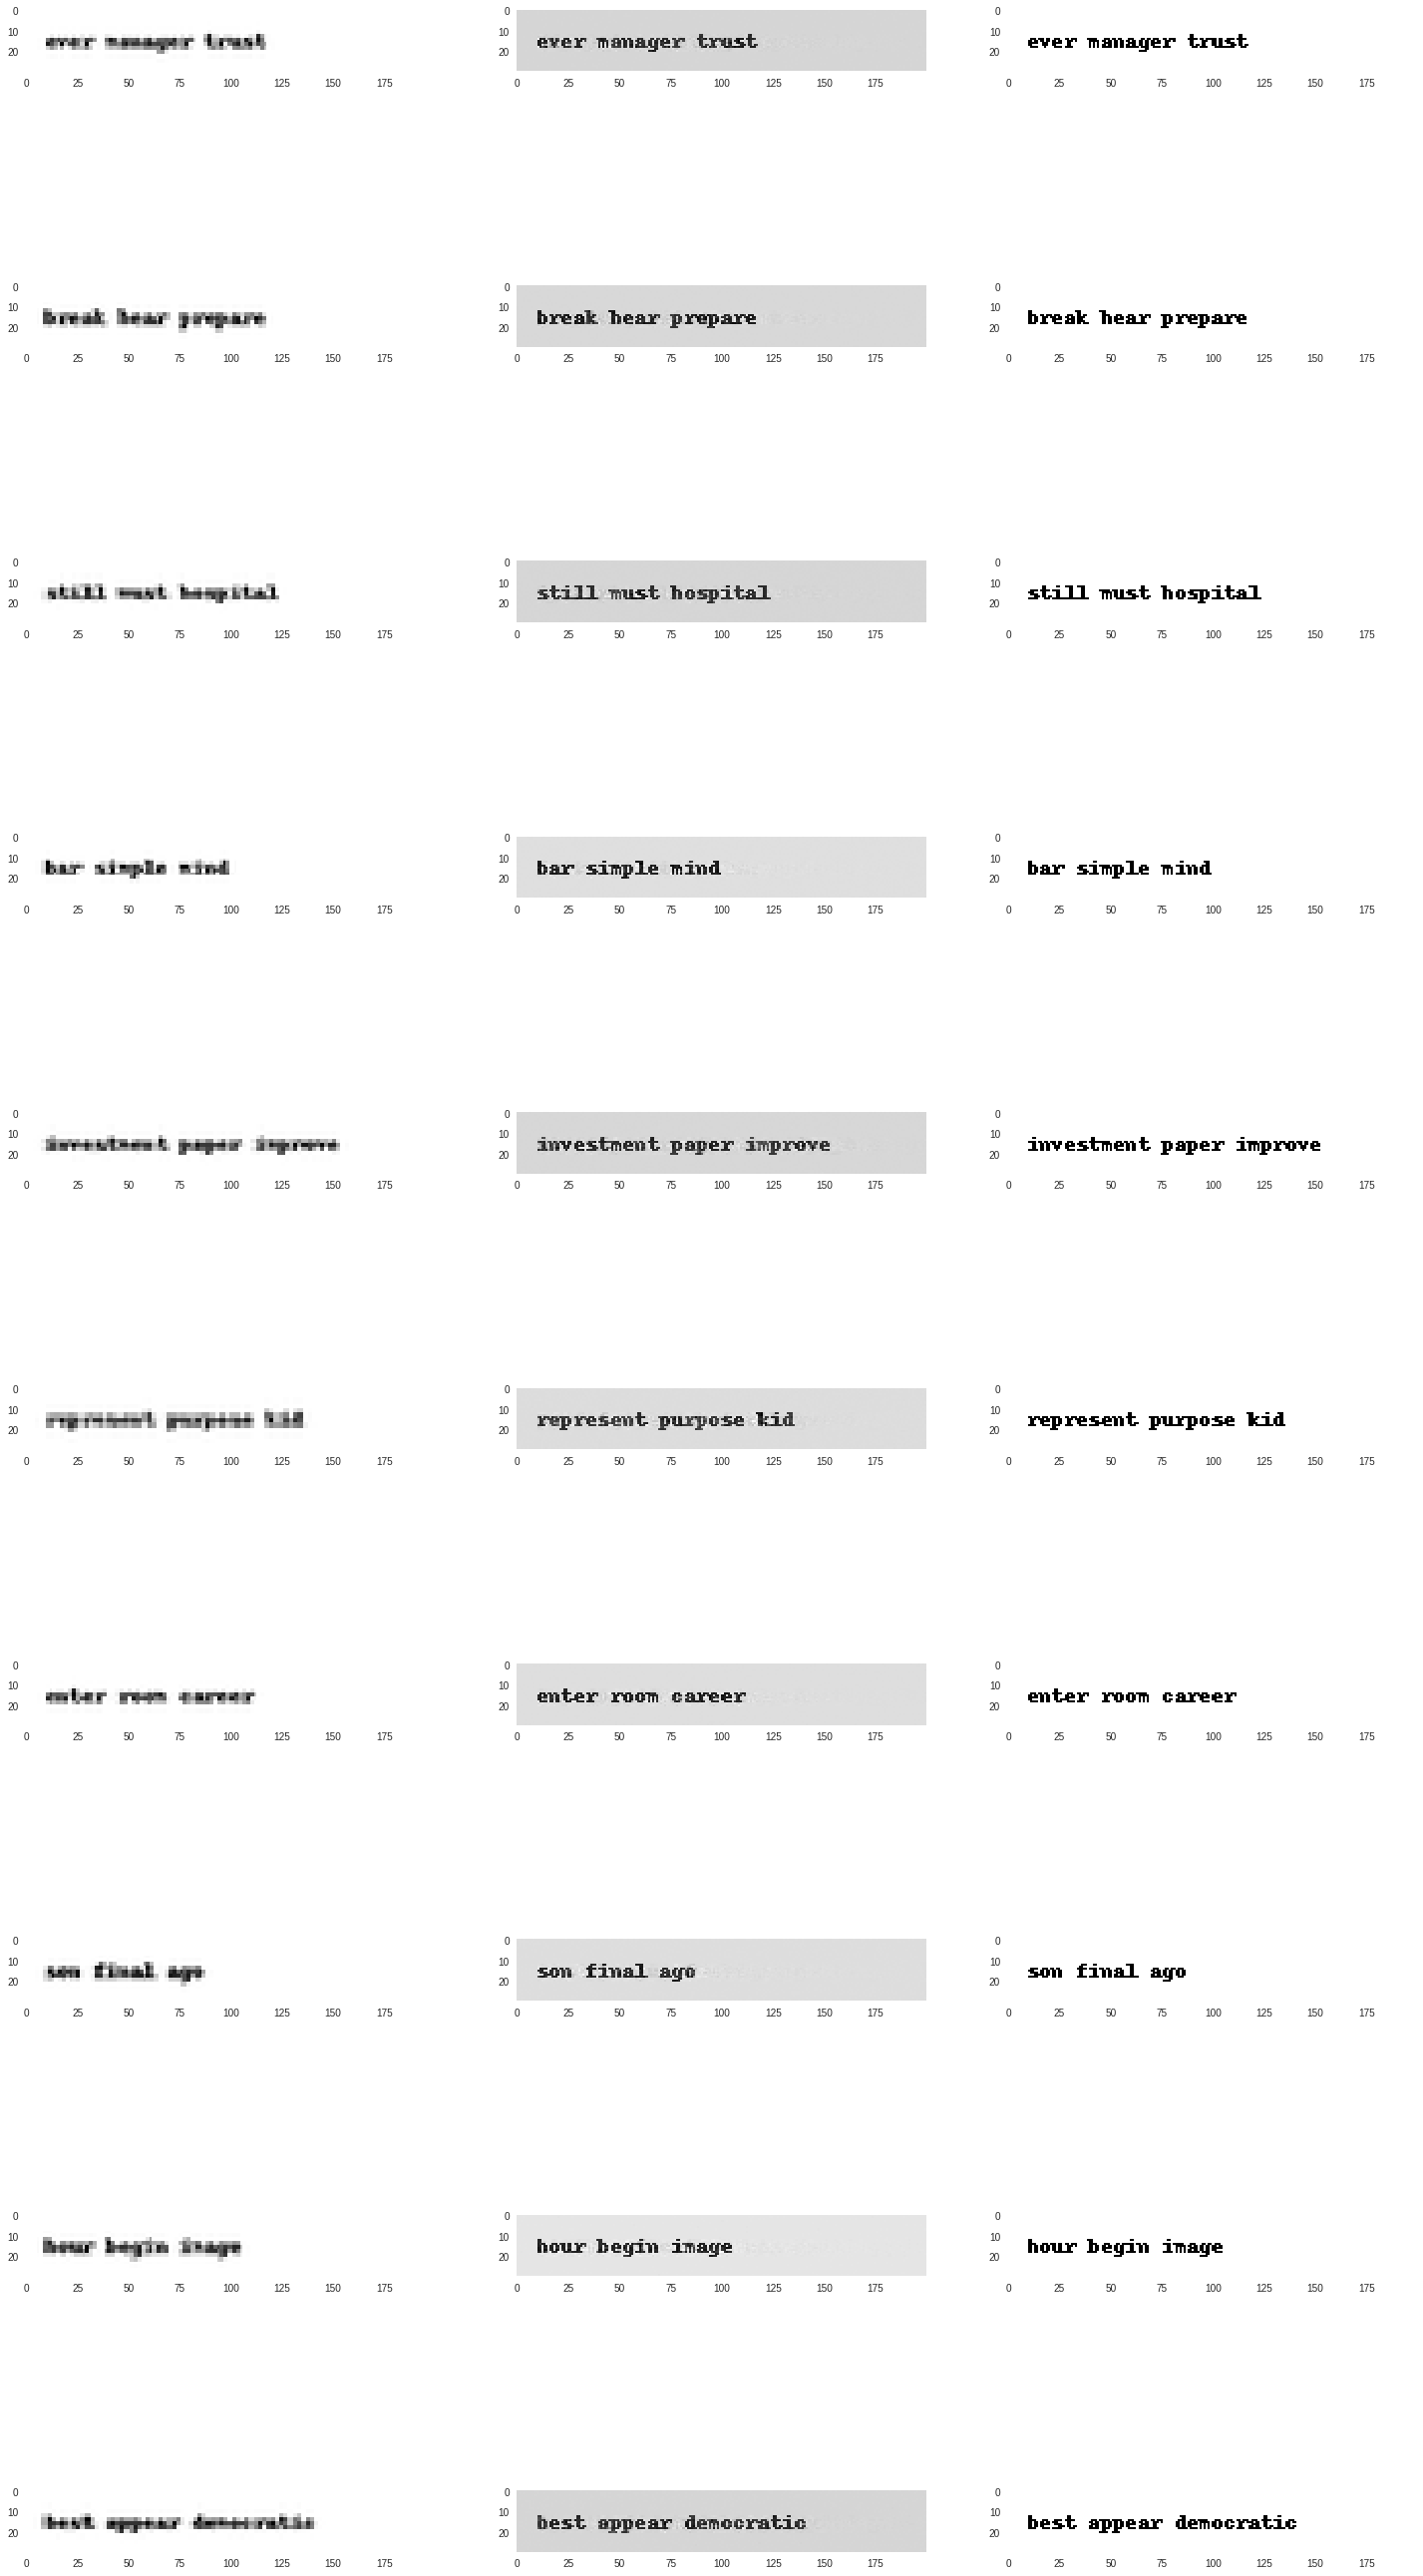

In [0]:
comparing(model, X_dev[:100], y_dev[:100])

In [0]:
import random
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont

ori_w = 300
ori_h = 50

# can be resize to 10% + 0~50% of the original
base_multi_w = int(ori_w*8/20)
base_multi_h = int(ori_h*8/20)
added_multi_w = int(ori_w*10/20)
added_multi_h = int(ori_h*10/20)

# wordbox has updated to 3000 words!
wordbox = ["a","abandon","ability","able","abortion","about","above","abroad","absence","absolute","absolutely","absorb","abuse","academic","accept","access","accident","accompany","accomplish","according","account","accurate","accuse","achieve","achievement","acid","acknowledge","acquire","across","act","action","active","activist","activity","actor","actress","actual","actually","ad","adapt","add","addition","additional","address","adequate","adjust","adjustment","administration","administrator","admire","admission","admit","adolescent","adopt","adult","advance","advanced","advantage","adventure","advertising","advice","advise","adviser","advocate","affair","affect","afford","afraid","African","African-American","after","afternoon","again","against","age","agency","agenda","agent","aggressive","ago","agree","agreement","agricultural","ah","ahead","aid","aide","AIDS","aim","air","aircraft","airline","airport","album","alcohol","alive","all","alliance","allow","ally","almost","alone","along","already","also","alter","alternative","although","always","AM","amazing","American","among","amount","analysis","analyst","analyze","ancient","and","anger","angle","angry","animal","anniversary","announce","annual","another","answer","anticipate","anxiety","any","anybody","anymore","anyone","anything","anyway","anywhere","apart","apartment","apparent","apparently","appeal","appear","appearance","apple","application","apply","appoint","appointment","appreciate","approach","appropriate","approval","approve","approximately","Arab","architect","area","argue","argument","arise","arm","armed","army","around","arrange","arrangement","arrest","arrival","arrive","art","article","artist","artistic","as","Asian","aside","ask","asleep","aspect","assault","assert","assess","assessment","asset","assign","assignment","assist","assistance","assistant","associate","association","assume","assumption","assure","at","athlete","athletic","atmosphere","attach","attack","attempt","attend","attention","attitude","attorney","attract","attractive","attribute","audience","author","authority","auto","available","average","avoid","award","aware","awareness","away","awful","baby","back","background","bad","badly","bag","bake","balance","ball","ban","band","bank","bar","barely","barrel","barrier","base","baseball","basic","basically","basis","basket","basketball","bathroom","battery","battle","be","beach","bean","bear","beat","beautiful","beauty","because","become","bed","bedroom","beer","before","begin","beginning","behavior","behind","being","belief","believe","bell","belong","below","belt","bench","bend","beneath","benefit","beside","besides","best","bet","better","between","beyond","Bible","big","bike","bill","billion","bind","biological","bird","birth","birthday","bit","bite","black","blade","blame","blanket","blind","block","blood","blow","blue","board","boat","body","bomb","bombing","bond","bone","book","boom","boot","border","born","borrow","boss","both","bother","bottle","bottom","boundary","bowl","box","boy","boyfriend","brain","branch","brand","bread","break","breakfast","breast","breath","breathe","brick","bridge","brief","briefly","bright","brilliant","bring","British","broad","broken","brother","brown","brush","buck","budget","build","building","bullet","bunch","burden","burn","bury","bus","business","busy","but","butter","button","buy","buyer","by","cabin","cabinet","cable","cake","calculate","call","camera","camp","campaign","campus","can","Canadian","cancer","candidate","cap","capability","capable","capacity","capital","captain","capture","car","carbon","card","care","career","careful","carefully","carrier","carry","case","cash","cast","cat","catch","category","Catholic","cause","ceiling","celebrate","celebration","celebrity","cell","center","central","century","CEO","ceremony","certain","certainly","chain","chair","chairman","challenge","chamber","champion","championship","chance","change","changing","channel","chapter","character","characteristic","characterize","charge","charity","chart","chase","cheap","check","cheek","cheese","chef","chemical","chest","chicken","chief","child","childhood","Chinese","chip","chocolate","choice","cholesterol","choose","Christian","Christmas","church","cigarette","circle","circumstance","cite","citizen","city","civil","civilian","claim","class","classic","classroom","clean","clear","clearly","client","climate","climb","clinic","clinical","clock","close","closely","closer","clothes","clothing","cloud","club","clue","cluster","coach","coal","coalition","coast","coat","code","coffee","cognitive","cold","collapse","colleague","collect","collection","collective","college","colonial","color","column","combination","combine","come","comedy","comfort","comfortable","command","commander","comment","commercial","commission","commit","commitment","committee","common","communicate","communication","community","company","compare","comparison","compete","competition","competitive","competitor","complain","complaint","complete","completely","complex","complicated","component","compose","composition","comprehensive","computer","concentrate","concentration","concept","concern","concerned","concert","conclude","conclusion","concrete","condition","conduct","conference","confidence","confident","confirm","conflict","confront","confusion","Congress","congressional","connect","connection","consciousness","consensus","consequence","conservative","consider","considerable","consideration","consist","consistent","constant","constantly","constitute","constitutional","construct","construction","consultant","consume","consumer","consumption","contact","contain","container","contemporary","content","contest","context","continue","continued","contract","contrast","contribute","contribution","control","controversial","controversy","convention","conventional","conversation","convert","conviction","convince","cook","cookie","cooking","cool","cooperation","cop","cope","copy","core","corn","corner","corporate","corporation","correct","correspondent","cost","cotton","couch","could","council","counselor","count","counter","country","county","couple","courage","course","court","cousin","cover","coverage","cow","crack","craft","crash","crazy","cream","create","creation","creative","creature","credit","crew","crime","criminal","crisis","criteria","critic","critical","criticism","criticize","crop","cross","crowd","crucial","cry","cultural","culture","cup","curious","current","currently","curriculum","custom","customer","cut","cycle","dad","daily","damage","dance","danger","dangerous","dare","dark","darkness","data","date","daughter","day","dead","deal","dealer","dear","death","debate","debt","decade","decide","decision","deck","declare","decline","decrease","deep","deeply","deer","defeat","defend","defendant","defense","defensive","deficit","define","definitely","definition","degree","delay","deliver","delivery","demand","democracy","Democrat","democratic","demonstrate","demonstration","deny","department","depend","dependent","depending","depict","depression","depth","deputy","derive","describe","description","desert","deserve","design","designer","desire","desk","desperate","despite","destroy","destruction","detail","detailed","detect","determine","develop","developing","development","device","devote","dialogue","die","diet","differ","difference","different","differently","difficult","difficulty","dig","digital","dimension","dining","dinner","direct","direction","directly","director","dirt","dirty","disability","disagree","disappear","disaster","discipline","discourse","discover","discovery","discrimination","discuss","discussion","disease","dish","dismiss","disorder","display","dispute","distance","distant","distinct","distinction","distinguish","distribute","distribution","district","diverse","diversity","divide","division","divorce","DNA","do","doctor","document","dog","domestic","dominant","dominate","door","double","doubt","down","downtown","dozen","draft","drag","drama","dramatic","dramatically","draw","drawing","dream","dress","drink","drive","driver","drop","drug","dry","due","during","dust","duty","each","eager","ear","early","earn","earnings","earth","ease","easily","east","eastern","easy","eat","economic","economics","economist","economy","edge","edition","editor","educate","education","educational","educator","effect","effective","effectively","efficiency","efficient","effort","egg","eight","either","elderly","elect","election","electric","electricity","electronic","element","elementary","eliminate","elite","else","elsewhere","e-mail","embrace","emerge","emergency","emission","emotion","emotional","emphasis","emphasize","employ","employee","employer","employment","empty","enable","encounter","encourage","end","enemy","energy","enforcement","engage","engine","engineer","engineering","English","enhance","enjoy","enormous","enough","ensure","enter","enterprise","entertainment","entire","entirely","entrance","entry","environment","environmental","episode","equal","equally","equipment","era","error","escape","especially","essay","essential","essentially","establish","establishment","estate","estimate","etc","ethics","ethnic","European","evaluate","evaluation","even","evening","event","eventually","ever","every","everybody","everyday","everyone","everything","everywhere","evidence","evolution","evolve","exact","exactly","examination","examine","example","exceed","excellent","except","exception","exchange","exciting","executive","exercise","exhibit","exhibition","exist","existence","existing","expand","expansion","expect","expectation","expense","expensive","experience","experiment","expert","explain","explanation","explode","explore","explosion","expose","exposure","express","expression","extend","extension","extensive","extent","external","extra","extraordinary","extreme","extremely","eye","fabric","face","facility","fact","factor","factory","faculty","fade","fail","failure","fair","fairly","faith","fall","FALSE","familiar","family","famous","fan","fantasy","far","farm","farmer","fashion","fast","fat","fate","father","fault","favor","favorite","fear","feature","federal","fee","feed","feel","feeling","fellow","female","fence","few","fewer","fiber","fiction","field","fifteen","fifth","fifty","fight","fighter","fighting","figure","file","fill","film","final","finally","finance","financial","find","finding","fine","finger","finish","fire","firm","first","fish","fishing","fit","fitness","five","fix","flag","flame","flat","flavor","flee","flesh","flight","float","floor","flow","flower","fly","focus","folk","follow","following","food","foot","football","for","force","foreign","forest","forever","forget","form","formal","formation","former","formula","forth","fortune","forward","found","foundation","founder","four","fourth","frame","framework","free","freedom","freeze","French","frequency","frequent","frequently","fresh","friend","friendly","friendship","from","front","fruit","frustration","fuel","full","fully","fun","function","fund","fundamental","funding","funeral","funny","furniture","furthermore","future","gain","galaxy","gallery","game","gang","gap","garage","garden","garlic","gas","gate","gather","gay","gaze","gear","gender","gene","general","generally","generate","generation","genetic","gentleman","gently","German","gesture","get","ghost","giant","gift","gifted","girl","girlfriend","give","given","glad","glance","glass","global","glove","go","goal","God","gold","golden","golf","good","government","governor","grab","grade","gradually","graduate","grain","grand","grandfather","grandmother","grant","grass","grave","gray","great","greatest","green","grocery","ground","group","grow","growing","growth","guarantee","guard","guess","guest","guide","guideline","guilty","gun","guy","habit","habitat","hair","half","hall","hand","handful","handle","hang","happen","happy","hard","hardly","hat","hate","have","he","head","headline","headquarters","health","healthy","hear","hearing","heart","heat","heaven","heavily","heavy","heel","height","helicopter","hell","hello","help","helpful","her","here","heritage","hero","herself","hey","hi","hide","high","highlight","highly","highway","hill","him","himself","hip","hire","his","historian","historic","historical","history","hit","hold","hole","holiday","holy","home","homeless","honest","honey","honor","hope","horizon","horror","horse","hospital","host","hot","hotel","hour","house","household","housing","how","however","huge","human","humor","hundred","hungry","hunter","hunting","hurt","husband","hypothesis","I","ice","idea","ideal","identification","identify","identity","ie","if","ignore","ill","illegal","illness","illustrate","image","imagination","imagine","immediate","immediately","immigrant","immigration","impact","implement","implication","imply","importance","important","impose","impossible","impress","impression","impressive","improve","improvement","in","incentive","incident","include","including","income","incorporate","increase","increased","increasing","increasingly","incredible","indeed","independence","independent","index","Indian","indicate","indication","individual","industrial","industry","infant","infection","inflation","influence","inform","information","ingredient","initial","initially","initiative","injury","inner","innocent","inquiry","inside","insight","insist","inspire","install","instance","instead","institution","institutional","instruction","instructor","instrument","insurance","intellectual","intelligence","intend","intense","intensity","intention","interaction","interest","interested","interesting","internal","international","Internet","interpret","interpretation","intervention","interview","into","introduce","introduction","invasion","invest","investigate","investigation","investigator","investment","investor","invite","involve","involved","involvement","Iraqi","Irish","iron","Islamic","island","Israeli","issue","it","Italian","item","its","itself","jacket","jail","Japanese","jet","Jew","Jewish","job","join","joint","joke","journal","journalist","journey","joy","judge","judgment","juice","jump","junior","jury","just","justice","justify","keep","key","kick","kid","kill","killer","killing","kind","king","kiss","kitchen","knee","knife","knock","know","knowledge","lab","label","labor","laboratory","lack","lady","lake","land","landscape","language","lap","large","largely","last","late","later","Latin","latter","laugh","launch","law","lawn","lawsuit","lawyer","lay","layer","lead","leader","leadership","leading","leaf","league","lean","learn","learning","least","leather","leave","left","leg","legacy","legal","legend","legislation","legitimate","lemon","length","less","lesson","let","letter","level","liberal","library","license","lie","life","lifestyle","lifetime","lift","light","like","likely","limit","limitation","limited","line","link","lip","list","listen","literally","literary","literature","little","live","living","load","loan","local","locate","location","lock","long","long-term","look","loose","lose","loss","lost","lot","lots","loud","love","lovely","lover","low","lower","luck","lucky","lunch","lung","machine","mad","magazine","mail","main","mainly","maintain","maintenance","major","majority","make","maker","makeup","male","mall","man","manage","management","manager","manner","manufacturer","manufacturing","many","map","margin","mark","market","marketing","marriage","married","marry","mask","mass","massive","master","match","material","math","matter","may","maybe","mayor","me","meal","mean","meaning","meanwhile","measure","measurement","meat","mechanism","media","medical","medication","medicine","medium","meet","meeting","member","membership","memory","mental","mention","menu","mere","merely","mess","message","metal","meter","method","Mexican","middle","might","military","milk","million","mind","mine","minister","minor","minority","minute","miracle","mirror","miss","missile","mission","mistake","mix","mixture","mm-hmm","mode","model","moderate","modern","modest","mom","moment","money","monitor","month","mood","moon","moral","more","moreover","morning","mortgage","most","mostly","mother","motion","motivation","motor","mount","mountain","mouse","mouth","move","movement","movie","Mr","Mrs","Ms","much","multiple","murder","muscle","museum","music","musical","musician","Muslim","must","mutual","my","myself","mystery","myth","naked","name","narrative","narrow","nation","national","native","natural","naturally","nature","near","nearby","nearly","necessarily","necessary","neck","need","negative","negotiate","negotiation","neighbor","neighborhood","neither","nerve","nervous","net","network","never","nevertheless","new","newly","news","newspaper","next","nice","night","nine","no","nobody","nod","noise","nomination","none","nonetheless","nor","normal","normally","north","northern","nose","not","note","nothing","notice","notion","novel","now","nowhere","n't","nuclear","number","numerous","nurse","nut","object","objective","obligation","observation","observe","observer","obtain","obvious","obviously","occasion","occasionally","occupation","occupy","occur","ocean","odd","odds","of","off","offense","offensive","offer","office","officer","official","often","oh","oil","ok","okay","old","Olympic","on","once","one","ongoing","onion","online","only","onto","open","opening","operate","operating","operation","operator","opinion","opponent","opportunity","oppose","opposite","opposition","option","or","orange","order","ordinary","organic","organization","organize","orientation","origin","original","originally","other","others","otherwise","ought","our","ourselves","out","outcome","outside","oven","over","overall","overcome","overlook","owe","own","owner","pace","pack","package","page","pain","painful","paint","painter","painting","pair","pale","Palestinian","palm","pan","panel","pant","paper","parent","park","parking","part","participant","participate","participation","particular","particularly","partly","partner","partnership","party","pass","passage","passenger","passion","past","patch","path","patient","pattern","pause","pay","payment","PC","peace","peak","peer","penalty","people","pepper","per","perceive","percentage","perception","perfect","perfectly","perform","performance","perhaps","period","permanent","permission","permit","person","personal","personality","personally","personnel","perspective","persuade","pet","phase","phenomenon","philosophy","phone","photo","photograph","photographer","phrase","physical","physically","physician","piano","pick","picture","pie","piece","pile","pilot","pine","pink","pipe","pitch","place","plan","plane","planet","planning","plant","plastic","plate","platform","play","player","please","pleasure","plenty","plot","plus","PM","pocket","poem","poet","poetry","point","pole","police","policy","political","politically","politician","politics","poll","pollution","pool","poor","pop","popular","population","porch","port","portion","portrait","portray","pose","position","positive","possess","possibility","possible","possibly","post","pot","potato","potential","potentially","pound","pour","poverty","powder","power","powerful","practical","practice","pray","prayer","precisely","predict","prefer","preference","pregnancy","pregnant","preparation","prepare","prescription","presence","present","presentation","preserve","president","presidential","press","pressure","pretend","pretty","prevent","previous","previously","price","pride","priest","primarily","primary","prime","principal","principle","print","prior","priority","prison","prisoner","privacy","private","probably","problem","procedure","proceed","process","produce","producer","product","production","profession","professional","professor","profile","profit","program","progress","project","prominent","promise","promote","prompt","proof","proper","properly","property","proportion","proposal","propose","proposed","prosecutor","prospect","protect","protection","protein","protest","proud","prove","provide","provider","province","provision","psychological","psychologist","psychology","public","publication","publicly","publish","publisher","pull","punishment","purchase","pure","purpose","pursue","push","put","qualify","quality","quarter","quarterback","question","quick","quickly","quiet","quietly","quit","quite","quote","race","racial","radical","radio","rail","rain","raise","range","rank","rapid","rapidly","rare","rarely","rate","rather","rating","ratio","raw","reach","react","reaction","read","reader","reading","ready","real","reality","realize","really","reason","reasonable","recall","receive","recent","recently","recipe","recognition","recognize","recommend","recommendation","record","recording","recover","recovery","recruit","red","reduce","reduction","refer","reference","reflect","reflection","reform","refugee","refuse","regard","regarding","regardless","regime","region","regional","register","regular","regularly","regulate","regulation","reinforce","reject","relate","relation","relationship","relative","relatively","relax","release","relevant","relief","religion","religious","rely","remain","remaining","remarkable","remember","remind","remote","remove","repeat","repeatedly","replace","reply","report","reporter","represent","representation","representative","Republican","reputation","request","require","requirement","research","researcher","resemble","reservation","resident","resist","resistance","resolution","resolve","resort","resource","respect","respond","respondent","response","responsibility","responsible","rest","restaurant","restore","restriction","result","retain","retire","retirement","return","reveal","revenue","review","revolution","rhythm","rice","rich","rid","ride","rifle","right","ring","rise","risk","river","road","rock","role","roll","romantic","roof","room","root","rope","rose","rough","roughly","round","route","routine","row","rub","rule","run","running","rural","rush","Russian","sacred","sad","safe","safety","sake","salad","salary","sale","sales","salt","same","sample","sanction","sand","satellite","satisfaction","satisfy","sauce","save","saving","say","scale","scandal","scared","scenario","scene","schedule","scheme","scholar","scholarship","school","science","scientific","scientist","scope","score","scream","screen","script","sea","search","season","seat","second","secret","secretary","section","sector","secure","security","see","seed","seek","seem","segment","seize","select","selection","self","sell","Senate","senator","send","senior","sense","sensitive","sentence","separate","sequence","series","serious","seriously","serve","service","session","set","setting","settle","settlement","seven","several","severe","sex","sexual","shade","shadow","shake","shall","shape","share","sharp","she","sheet","shelf","shell","shelter","shift","shine","ship","shirt","shit","shock","shoe","shoot","shooting","shop","shopping","shore","short","shortly","shot","should","shoulder","shout","show","shower","shrug","shut","sick","side","sigh","sight","sign","signal","significance","significant","significantly","silence","silent","silver","similar","similarly","simple","simply","sin","since","sing","singer","single","sink","sir","sister","sit","site","situation","six","size","ski","skill","skin","sky","slave","sleep","slice","slide","slight","slightly","slip","slow","slowly","small","smart","smell","smile","smoke","smooth","snap","snow","so","so-called","soccer","social","society","soft","software","soil","solar","soldier","solid","solution","solve","some","somebody","somehow","someone","something","sometimes","somewhat","somewhere","son","song","soon","sophisticated","sorry","sort","soul","sound","soup","source","south","southern","Soviet","space","Spanish","speak","speaker","special","specialist","species","specific","specifically","speech","speed","spend","spending","spin","spirit","spiritual","split","spokesman","sport","spot","spread","spring","square","squeeze","stability","stable","staff","stage","stair","stake","stand","standard","standing","star","stare","start","state","statement","station","statistics","status","stay","steady","steal","steel","step","stick","still","stir","stock","stomach","stone","stop","storage","store","storm","story","straight","strange","stranger","strategic","strategy","stream","street","strength","strengthen","stress","stretch","strike","string","strip","stroke","strong","strongly","structure","struggle","student","studio","study","stuff","stupid","style","subject","submit","subsequent","substance","substantial","succeed","success","successful","successfully","such","sudden","suddenly","sue","suffer","sufficient","sugar","suggest","suggestion","suicide","suit","summer","summit","sun","super","supply","support","supporter","suppose","supposed","Supreme","sure","surely","surface","surgery","surprise","surprised","surprising","surprisingly","surround","survey","survival","survive","survivor","suspect","sustain","swear","sweep","sweet","swim","swing","switch","symbol","symptom","system","table","tablespoon","tactic","tail","take","tale","talent","talk","tall","tank","tap","tape","target","task","taste","tax","taxpayer","tea","teach","teacher","teaching","team","tear","teaspoon","technical","technique","technology","teen","teenager","telephone","telescope","television","tell","temperature","temporary","ten","tend","tendency","tennis","tension","tent","term","terms","terrible","territory","terror","terrorism","terrorist","test","testify","testimony","testing","text","than","thank","thanks","that","the","theater","their","them","theme","themselves","then","theory","therapy","there","therefore","these","they","thick","thin","thing","think","thinking","third","thirty","this","those","though","thought","thousand","threat","threaten","three","throat","through","throughout","throw","thus","ticket","tie","tight","time","tiny","tip","tire","tired","tissue","title","to","tobacco","today","toe","together","tomato","tomorrow","tone","tongue","tonight","too","tool","tooth","top","topic","toss","total","totally","touch","tough","tour","tourist","tournament","toward","towards","tower","town","toy","trace","track","trade","tradition","traditional","traffic","tragedy","trail","train","training","transfer","transform","transformation","transition","translate","transportation","travel","treat","treatment","treaty","tree","tremendous","trend","trial","tribe","trick","trip","troop","trouble","truck","TRUE","truly","trust","truth","try","tube","tunnel","turn","TV","twelve","twenty","twice","twin","two","type","typical","typically","ugly","ultimate","ultimately","unable","uncle","under","undergo","understand","understanding","unfortunately","uniform","union","unique","unit","United","universal","universe","university","unknown","unless","unlike","unlikely","until","unusual","up","upon","upper","urban","urge","us","use","used","useful","user","usual","usually","utility","vacation","valley","valuable","value","variable","variation","variety","various","vary","vast","vegetable","vehicle","venture","version","versus","very","vessel","veteran","via","victim","victory","video","view","viewer","village","violate","violation","violence","violent","virtually","virtue","virus","visible","vision","visit","visitor","visual","vital","voice","volume","volunteer","vote","voter","vs","vulnerable","wage","wait","wake","walk","wall","wander","want","war","warm","warn","warning","wash","waste","watch","water","wave","way","we","weak","wealth","wealthy","weapon","wear","weather","wedding","week","weekend","weekly","weigh","weight","welcome","welfare","well","west","western","wet","what","whatever","wheel","when","whenever","where","whereas","whether","which","while","whisper","white","who","whole","whom","whose","why","wide","widely","widespread","wife","wild","will","willing","win","wind","window","wine","wing","winner","winter","wipe","wire","wisdom","wise","wish","with","withdraw","within","without","witness","woman","wonder","wonderful","wood","wooden","word","work","worker","working","works","workshop","world","worried","worry","worth","would","wound","wrap","write","writer","writing","wrong","yard","yeah","year","yell","yellow","yes","yesterday","yet","yield","you","young","your","yours","yourself","youth","zone"]
# fontbox = ['arial.ttf','bahnschrift.ttf','calibri.ttf','corbel.ttf','ebrima.ttf','georgia.ttf','impact.ttf','tahoma.ttf','times.ttf','verdana.ttf']
fontbox = ['LiberationMono-Regular.ttf', 'LiberationSans-Regular.ttf', 'LiberationSerif-Regular.ttf', 'Calibri.ttf', 'arial.ttf', 'Tahoma Regular font.ttf']
bgs = [(236,242,247), (236,247,240), (247,236,245), (255,255,255)]

for i in tqdm(range(20000)):
    target_dir = 'datav7/test20000'
    
#     img = Image.new('RGB',(ori_w, ori_h),(random.randrange(256),random.randrange(256),random.randrange(256)))
#     img = Image.new('RGB',(ori_w, ori_h),(230,233,240))
    img = Image.new('RGB',(ori_w, ori_h), bgs[random.randrange(len(bgs))])
#     font = ImageFont.truetype(fontbox[random.randrange(10)], 35 + random.randrange(35))
    font = ImageFont.truetype('drive/My Drive/computer_vision/fonts/' + fontbox[random.randrange(len(fontbox))], 25)
    position = (random.randrange(50),random.randrange(30))
    n = 3 + random.randrange(3)  #random 3 to 5 words

    message = ''
    for j in range(n):
        message = message + ' ' + wordbox[random.randrange(3000)]

    draw = ImageDraw.Draw(img)
#     draw.text(position, message,(random.randrange(256),random.randrange(256),random.randrange(256)), font)
    draw.text(position, message,(0,0,0), font)
    
    img.save(target_dir + '/ori/ori' + str(i) + '.png')
    
# --Down-sample--
    aw = random.randrange(added_multi_w)
    ah = random.randrange(added_multi_h)
    img2 = img.copy()
    img2 = img2.resize((base_multi_w + aw,base_multi_h + ah), Image.ANTIALIAS)  
    img2 = img2.resize((ori_w,ori_h))

    img2.save(target_dir + '/down/down' + str(i) + '.png')
    
    img = cv2.imread(target_dir + '/ori/ori' + str(i) + '.png')
    
# --Median Blur-- kernelSizeได้แค่นี้เพราะรูปเล็ก--
    ks = random.randrange(3,5+1,2)
    img3 = img.copy()
    img3 = cv2.medianBlur(img3,ks)
    cv2.imwrite(target_dir + '/median/median' + str(i) + '.png', img3)
    
# --Gaussian Blur--
    ks = random.randrange(3,7+1,2)
    sx = random.randrange(3,7+1,2)
    img4 = img.copy()
    img4 = cv2.GaussianBlur(img4,(ks,ks),sx)
    cv2.imwrite(target_dir + '/gaussian/gaussian' + str(i) + '.png', img4)

100%|██████████| 20000/20000 [02:36<00:00, 127.65it/s]


In [0]:
!rm -r datav7
!mkdir -p datav7/dev20000/ori
!mkdir -p datav7/dev20000/down
!mkdir -p datav7/dev20000/median
!mkdir -p datav7/dev20000/gaussian
!mkdir -p datav7/train30000/ori
!mkdir -p datav7/train30000/down
!mkdir -p datav7/train30000/median
!mkdir -p datav7/train30000/gaussian
!mkdir -p datav7/test20000/ori
!mkdir -p datav7/test20000/down
!mkdir -p datav7/test20000/median
!mkdir -p datav7/test20000/gaussian

In [0]:
!mkdir -p datav7/test20000/ori
!mkdir -p datav7/test20000/down
!mkdir -p datav7/test20000/median
!mkdir -p datav7/test20000/gaussian

In [0]:
!ls /usr/share/fonts/truetype/liberation

LiberationMono-BoldItalic.ttf	     LiberationSansNarrow-Bold.ttf
LiberationMono-Bold.ttf		     LiberationSansNarrow-Italic.ttf
LiberationMono-Italic.ttf	     LiberationSansNarrow-Regular.ttf
LiberationMono-Regular.ttf	     LiberationSans-Regular.ttf
LiberationSans-BoldItalic.ttf	     LiberationSerif-BoldItalic.ttf
LiberationSans-Bold.ttf		     LiberationSerif-Bold.ttf
LiberationSans-Italic.ttf	     LiberationSerif-Italic.ttf
LiberationSansNarrow-BoldItalic.ttf  LiberationSerif-Regular.ttf


In [0]:
!ls drive/My\ Drive/computer_vision/fonts/.

 arial.ttf     LiberationMono-Regular.ttf   LiberationSerif-Regular.ttf
 Calibri.ttf   LiberationSans-Regular.ttf  'Tahoma Regular font.ttf'


In [0]:
!rm -r datav7/dev20000

In [0]:
!mv datav7/train30000 datav7/dev20000

In [0]:
%%capture
!tar -cvzf datav7.tar.gz datav7/

In [0]:
!cp datav7.tar.gz drive/My\ Drive/computer_vision/.